#old

In [ ]:
!pip install opendatasets librosa soundfile tqdm --quiet

import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm

import librosa
import soundfile as sf
import opendatasets as od

In [ ]:
name="vladluca96"
key="KGAT_a6796e51d22cd80f8cd869b9e4618fee"

In [ ]:

# --- use the `name` and `key` variables to configure Kaggle ---
os.makedirs('/root/.kaggle', exist_ok=True)

creds = {
    "username": name,
    "key": key
}

with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(creds, f)

os.chmod('/root/.kaggle/kaggle.json', 0o600)
print("Kaggle credentials written to /root/.kaggle/kaggle.json")

Kaggle credentials written to /root/.kaggle/kaggle.json


In [ ]:
DATA_ROOT = "/content/data"
os.makedirs(DATA_ROOT, exist_ok=True)

dataset_url = "https://www.kaggle.com/datasets/rtatman/speech-accent-archive"

od.download(dataset_url, data_dir=DATA_ROOT)

print("Download finished. Folder structure:")
for root, dirs, files in os.walk(DATA_ROOT):
    level = root.replace(DATA_ROOT, "").count(os.sep)
    indent = " " * (2 * level)
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * (2 * (level + 1))
    for f in files[:5]:
        print(f"{subindent}{f}")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vladluca96
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/rtatman/speech-accent-archive


100%|██████████| 865M/865M [00:08<00:00, 106MB/s] 



Download finished. Folder structure:
data/
  speech-accent-archive/
    reading-passage.txt
    speakers_all.csv
    recordings/
      recordings/
        spanish46.mp3
        tagalog2.mp3
        chaldean2.mp3
        spanish54.mp3
        portuguese47.mp3


In [ ]:
speakers_csv_path = None
recordings_dir = None

for root, dirs, files in os.walk(DATA_ROOT):
    for f in files:
        if f == "speakers_all.csv":
            speakers_csv_path = os.path.join(root, f)
    for d in dirs:
        if d.lower() == "recordings":
            recordings_dir = os.path.join(root, d)

print("speakers_all.csv:", speakers_csv_path)
print("recordings dir:", recordings_dir)

assert speakers_csv_path is not None, "Could not find speakers_all.csv"
assert recordings_dir is not None, "Could not find recordings directory"


speakers_all.csv: /content/data/speech-accent-archive/speakers_all.csv
recordings dir: /content/data/speech-accent-archive/recordings/recordings


In [ ]:
speakers_df = pd.read_csv(speakers_csv_path)
print("Columns:", speakers_df.columns.tolist())
speakers_df.head()


Columns: ['age', 'age_onset', 'birthplace', 'filename', 'native_language', 'sex', 'speakerid', 'country', 'file_missing?', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11']


age  age_onset              birthplace  filename native_language   sex  \
0  24.0       12.0         koussi, senegal   balanta         balanta  male   
1  18.0       10.0          buea, cameroon  cameroon        cameroon  male   
2  48.0        8.0  hong, adamawa, nigeria  fulfulde        fulfulde  male   
3  42.0       42.0   port-au-prince, haiti   haitian         haitian  male   
4  40.0       35.0   port-au-prince, haiti   haitian         haitian  male   

   speakerid   country  file_missing?  Unnamed: 9  Unnamed: 10 Unnamed: 11  
0        788   senegal           True         NaN          NaN         NaN  
1       1953  cameroon           True         NaN          NaN         NaN  
2       1037   nigeria           True         NaN          NaN         NaN  
3       1165     haiti           True         NaN          NaN         NaN  
4       1166     haiti           True         NaN          NaN         NaN

In [ ]:
print("Top native languages by count:")
print(speakers_df['native_language'].value_counts().head(20))


Top native languages by count:
native_language
english       579
spanish       162
arabic        102
mandarin       65
french         63
korean         52
portuguese     48
russian        48
dutch          47
turkish        37
german         36
polish         34
italian        33
japanese       27
macedonian     26
cantonese      23
farsi          23
vietnamese     22
swedish        20
amharic        20
Name: count, dtype: int64


In [ ]:
MIN_SAMPLES = 40  # tweak as you like

lang_counts = speakers_df['native_language'].value_counts()
selected_langs = lang_counts[lang_counts >= MIN_SAMPLES].index.tolist()

print("Selected native languages (accent classes):")
print(selected_langs)

subset_df = speakers_df[speakers_df['native_language'].isin(selected_langs)].copy()

# if dataset has 'file_missing?' column, remove missing files
if 'file_missing?' in subset_df.columns:
    subset_df = subset_df[~subset_df['file_missing?']]

print("Subset size before audio-path filter:", len(subset_df))
subset_df.head()


Selected native languages (accent classes):
['english', 'spanish', 'arabic', 'mandarin', 'french', 'korean', 'portuguese', 'russian', 'dutch']
Subset size before audio-path filter: 1166


age  age_onset            birthplace   filename native_language     sex  \
70  38.0       12.0  riyadh, saudi arabia    arabic1          arabic  female   
71  26.0        5.0          cairo, egypt   arabic10          arabic    male   
72  40.0       10.0       beirut, lebanon  arabic100          arabic  female   
73  21.0       10.0           doha, qatar  arabic101          arabic    male   
74  22.0        3.0  jiddah, saudi arabia  arabic102          arabic    male   

    speakerid       country  file_missing?  Unnamed: 9  Unnamed: 10  \
70         11  saudi arabia          False         NaN          NaN   
71         12         egypt          False         NaN          NaN   
72       2159       lebanon          False         NaN          NaN   
73       2160         qatar          False         NaN          NaN   
74       2161  saudi arabia          False         NaN          NaN   

   Unnamed: 11  
70         NaN  
71         NaN  
72         NaN  
73         NaN  
74         NaN

In [ ]:
def get_audio_path(row, base_dir=recordings_dir):
    base_name = str(row['filename']).strip()
    cand_mp3 = os.path.join(base_dir, base_name + ".mp3")
    cand_wav = os.path.join(base_dir, base_name + ".wav")

    if os.path.exists(cand_mp3):
        return cand_mp3
    if os.path.exists(cand_wav):
        return cand_wav
    return None

subset_df['audio_path'] = subset_df.apply(get_audio_path, axis=1)

print("Missing paths:", subset_df['audio_path'].isna().sum())
subset_df = subset_df[subset_df['audio_path'].notna()].reset_index(drop=True)
print("After dropping missing audio:", len(subset_df))
subset_df[['filename', 'native_language', 'audio_path']].head()


Missing paths: 0
After dropping missing audio: 1166


filename native_language  \
0    arabic1          arabic   
1   arabic10          arabic   
2  arabic100          arabic   
3  arabic101          arabic   
4  arabic102          arabic   

                                          audio_path  
0  /content/data/speech-accent-archive/recordings...  
1  /content/data/speech-accent-archive/recordings...  
2  /content/data/speech-accent-archive/recordings...  
3  /content/data/speech-accent-archive/recordings...  
4  /content/data/speech-accent-archive/recordings...

In [ ]:
SAMPLE_RATE = 16000
N_MFCC = 20

def extract_mfcc_features(audio_path, sr=SAMPLE_RATE, n_mfcc=N_MFCC):
    try:
        y, sr = librosa.load(audio_path, sr=sr, mono=True)
        if len(y) == 0:
            return None

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_mean = mfcc.mean(axis=1)
        mfcc_std = mfcc.std(axis=1)

        feat_vec = np.concatenate([mfcc_mean, mfcc_std])
        return feat_vec
    except Exception as e:
        # uncomment if you want details:
        # print(f"Error for {audio_path}: {e}")
        return None


In [ ]:
features = []
labels = []
file_ids = []

for idx, row in tqdm(subset_df.iterrows(), total=len(subset_df)):
    path = row['audio_path']
    feat = extract_mfcc_features(path)
    if feat is None:
        continue
    features.append(feat)
    labels.append(row['native_language'])
    file_ids.append(row['filename'])

X = np.vstack(features)
y = np.array(labels)

print("Feature matrix shape:", X.shape)  # (num_samples, 40)
print("Labels shape:", y.shape)
print("Unique labels:", np.unique(y))


100%|██████████| 1166/1166 [02:09<00:00,  9.03it/s]

Feature matrix shape: (1166, 40)
Labels shape: (1166,)
Unique labels: ['arabic' 'dutch' 'english' 'french' 'korean' 'mandarin' 'portuguese'
 'russian' 'spanish']


In [ ]:
mfcc_cols = [f"mfcc_mean_{i}" for i in range(N_MFCC)] + \
            [f"mfcc_std_{i}" for i in range(N_MFCC)]

feat_df = pd.DataFrame(X, columns=mfcc_cols)
feat_df['label'] = y
feat_df['filename'] = file_ids

feat_df.head()


mfcc_mean_0  mfcc_mean_1  mfcc_mean_2  mfcc_mean_3  mfcc_mean_4  \
0  -224.994171    73.402405    25.411341    39.823063    -3.633636   
1  -317.993225    91.502502     3.522352    33.125679     9.820498   
2  -301.683014    83.621933     6.520702     0.942819   -19.574402   
3  -295.303894    70.759445    12.306586    37.385490   -11.383186   
4  -226.140289    76.879829    49.834213    30.755690    11.831662   

   mfcc_mean_5  mfcc_mean_6  mfcc_mean_7  mfcc_mean_8  mfcc_mean_9  ...  \
0     0.172402     3.392362    -2.965713    -9.197946    -1.805289  ...   
1    -1.162950     2.676643   -17.048788    -8.816577     4.839348  ...   
2   -14.884485   -17.035654   -12.812116   -14.829546    -4.771919  ...   
3   -11.308743   -18.007145   -11.644006   -18.473969   -19.062325  ...   
4   -11.393529   -19.998714     8.736276   -11.788992    -8.245823  ...   

   mfcc_std_12  mfcc_std_13  mfcc_std_14  mfcc_std_15  mfcc_std_16  \
0     5.922597     8.204150     6.957012     5.650662     8.099861   
1    10.038940     7.294832     6.219815     8.145192     6.410264   
2     6.687846     6.818860     6.067121     5.941235     6.544685   
3     8.246466     8.596560     7.163092     7.160876     5.954243   
4     8.934765     7.203803     6.872486     7.507259     7.959385   

   mfcc_std_17  mfcc_std_18  mfcc_std_19   label   filename  
0     5.742603     5.973695     5.862728  arabic    arabic1  
1     5.738501     6.385526     5.428969  arabic   arabic10  
2     5.880397     5.702448     6.346673  arabic  arabic100  
3     5.806413     5.979983     5.977483  arabic  arabic101  
4     9.166691     7.441134     7.247542  arabic  arabic102  

[5 rows x 42 columns]

In [ ]:
import pandas as pd

# Assume feat_df already exists
print("Class distribution (all labels):")
print(feat_df['label'].value_counts())

TOP_N = 5  # you can change this
top_labels = feat_df['label'].value_counts().head(TOP_N).index.tolist()
print(f"\nKeeping top {TOP_N} labels:", top_labels)

df_balanced = feat_df[feat_df['label'].isin(top_labels)].copy()
print("New size:", len(df_balanced))
print("\nBalanced distribution:")
print(df_balanced['label'].value_counts())


Class distribution (all labels):
label
english       579
spanish       162
arabic        102
mandarin       65
french         63
korean         52
portuguese     48
russian        48
dutch          47
Name: count, dtype: int64

Keeping top 5 labels: ['english', 'spanish', 'arabic', 'mandarin', 'french']
New size: 971

Balanced distribution:
label
english     579
spanish     162
arabic      102
mandarin     65
french       63
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Use all MFCC columns as features
feature_cols = [c for c in df_balanced.columns if c.startswith('mfcc_')]

X = df_balanced[feature_cols].values
y = df_balanced['label'].values

# Encode string labels -> integers
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Classes:", le.classes_)

# Scale features (important for LogReg / SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train shape: (776, 40)
Test shape: (195, 40)
Classes: ['arabic' 'english' 'french' 'mandarin' 'spanish']


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

logreg = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    n_jobs=-1
)
logreg.fit(X_train_scaled, y_train)

y_pred_logreg = logreg.predict(X_test_scaled)

print("Logistic Regression accuracy:",
      accuracy_score(y_test, y_pred_logreg))

print("\nClassification report (Logistic Regression):")
print(classification_report(y_test, y_pred_logreg,
                            target_names=le.classes_))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression accuracy: 0.5897435897435898

Classification report (Logistic Regression):
              precision    recall  f1-score   support

      arabic       0.33      0.15      0.21        20
     english       0.66      0.86      0.75       116
      french       0.33      0.08      0.12        13
    mandarin       0.17      0.08      0.11        13
     spanish       0.38      0.30      0.34        33

    accuracy                           0.59       195
   macro avg       0.38      0.29      0.31       195
weighted avg       0.53      0.59      0.54       195



In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(
    kernel='linear',
    probability=False
)
svm_clf.fit(X_train_scaled, y_train)

y_pred_svm = svm_clf.predict(X_test_scaled)

print("SVM (linear) accuracy:",
      accuracy_score(y_test, y_pred_svm))

print("\nClassification report (SVM):")
print(classification_report(y_test, y_pred_svm,
                            target_names=le.classes_))


SVM (linear) accuracy: 0.6

Classification report (SVM):
              precision    recall  f1-score   support

      arabic       0.22      0.10      0.14        20
     english       0.64      0.95      0.76       116
      french       0.00      0.00      0.00        13
    mandarin       0.00      0.00      0.00        13
     spanish       0.50      0.15      0.23        33

    accuracy                           0.60       195
   macro avg       0.27      0.24      0.23       195
weighted avg       0.49      0.60      0.51       195



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


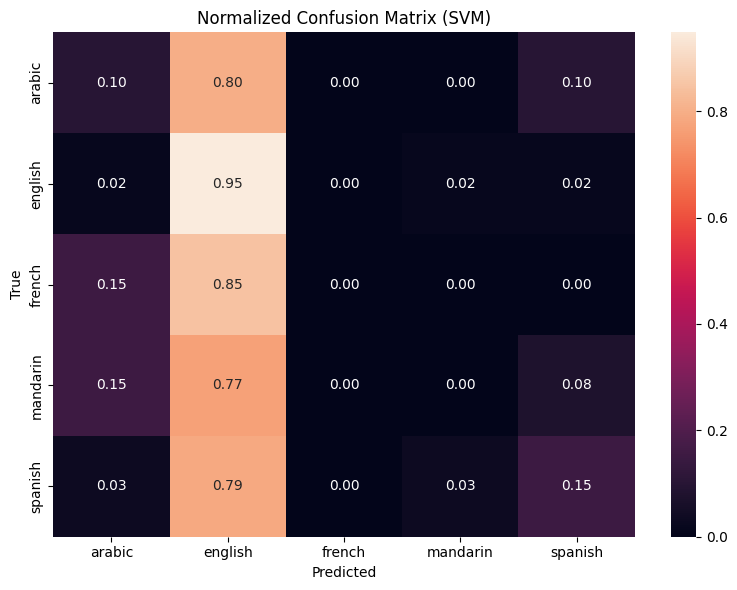

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_svm)  # or y_pred_logreg
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm,
            annot=True, fmt=".2f",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (SVM)")
plt.tight_layout()
plt.show()


In [ ]:
# Check class balance in the dataset you actually used for training
print(df_balanced['label'].value_counts())

# Make sure df_balanced and subset_df are aligned:
print(df_balanced['label'].unique())
print(subset_df['native_language'].unique())


label
english     579
spanish     162
arabic      102
mandarin     65
french       63
Name: count, dtype: int64
['arabic' 'english' 'french' 'mandarin' 'spanish']
['arabic' 'dutch' 'english' 'french' 'korean' 'mandarin' 'portuguese'
 'russian' 'spanish']


In [ ]:
import pandas as pd

TARGET_CLASSES = ["english", "spanish", "arabic"]
SAMPLES_PER_CLASS = 100

df_balanced = (
    subset_df[subset_df['native_language'].isin(TARGET_CLASSES)]
    .groupby("native_language", group_keys=False)
    .apply(lambda x: x.sample(n=SAMPLES_PER_CLASS, random_state=42))
    .reset_index(drop=True)
)

print(df_balanced['native_language'].value_counts())


native_language
arabic     100
english    100
spanish    100
Name: count, dtype: int64


/tmp/ipython-input-434322893.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=SAMPLES_PER_CLASS, random_state=42))


In [ ]:
df_balanced_feats = feat_df.merge(
    df_balanced[['filename', 'native_language']],
    left_on='filename',
    right_on='filename'
)

df_balanced_feats['label'] = df_balanced_feats['native_language']

print(df_balanced_feats['label'].value_counts())


label
arabic     100
english    100
spanish    100
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Feature columns
feature_cols = [c for c in df_balanced_feats.columns if c.startswith("mfcc_")]

X = df_balanced_feats[feature_cols].values
y = df_balanced_feats['label'].values

# encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)

# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# model
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

# evaluate
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.55

Classification report:
              precision    recall  f1-score   support

      arabic       0.58      0.70      0.64        20
     english       0.58      0.55      0.56        20
     spanish       0.47      0.40      0.43        20

    accuracy                           0.55        60
   macro avg       0.54      0.55      0.54        60
weighted avg       0.54      0.55      0.54        60



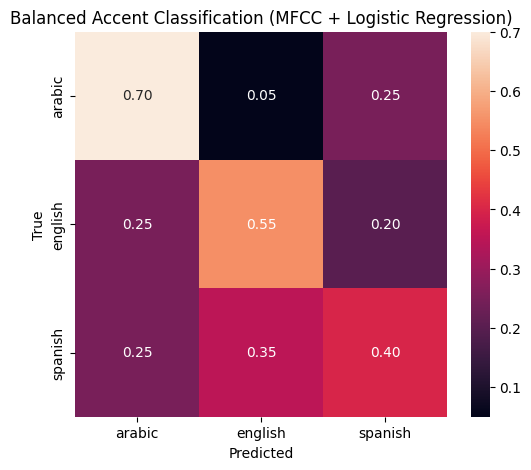

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm,
            annot=True, fmt=".2f",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Balanced Accent Classification (MFCC + Logistic Regression)")
plt.show()


In [ ]:
from IPython.display import Audio, display
import numpy as np

def play_sample(df, label, n=2):
    rows = df[df['native_language'] == label].sample(n=n, random_state=42)
    print(f"\n=== {label.upper()} ===")
    for _, row in rows.iterrows():
        print("File:", row['filename'])
        display(Audio(filename=row['audio_path']))

for cls in TARGET_CLASSES:
    play_sample(df_balanced, cls, n=2)



=== ENGLISH ===
File: english180


File: english29



=== SPANISH ===
File: spanish37


File: spanish3



=== ARABIC ===
File: arabic92


File: arabic29


In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=10, gamma='scale')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))


Accuracy: 0.48333333333333334
              precision    recall  f1-score   support

      arabic       0.45      0.50      0.48        20
     english       0.55      0.55      0.55        20
     spanish       0.44      0.40      0.42        20

    accuracy                           0.48        60
   macro avg       0.48      0.48      0.48        60
weighted avg       0.48      0.48      0.48        60



In [ ]:
import librosa
import numpy as np

def extract_mfcc_with_deltas(path):
    y, sr = librosa.load(path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)

    delta1 = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)

    features = np.vstack([mfcc, delta1, delta2])
    return np.concatenate([features.mean(axis=1), features.std(axis=1)])


In [ ]:
# assumes speakers_df is already loaded from speakers_all.csv

english_df = speakers_df[speakers_df['native_language'].str.lower() == "english"].copy()

print("Number of native English speakers:", len(english_df))
english_df.head()


Number of native English speakers: 579


age  age_onset                     birthplace    filename  \
363  42.0        0.0  pittsburgh, pennsylvania, usa    english1   
364  35.0        0.0           davenport, iowa, usa   english10   
365  23.0        0.0            miami, florida, usa  english100   
366  18.0        0.0       toronto, ontario, canada  english101   
367  22.0        0.0   torrington, connecticut, usa  english102   

    native_language     sex  speakerid country  file_missing?  Unnamed: 9  \
363         english    male         61     usa          False         NaN   
364         english  female         62     usa          False         NaN   
365         english  female         63     usa          False         NaN   
366         english  female         64  canada          False         NaN   
367         english    male         65     usa          False         NaN   

     Unnamed: 10 Unnamed: 11  
363          NaN         NaN  
364          NaN         NaN  
365          NaN         NaN  
366          NaN         NaN  
367          NaN         NaN

In [ ]:
print("Available columns:")
for c in english_df.columns:
    print(c)


Available columns:
age
age_onset
birthplace
filename
native_language
sex
speakerid
country
file_missing?
Unnamed: 9
Unnamed: 10
Unnamed: 11


In [ ]:
loc_cols = [c for c in english_df.columns if
            "birth" in c.lower() or
            "place" in c.lower() or
            "country" in c.lower() or
            "origin" in c.lower() or
            "location" in c.lower()]

print("Candidate location columns:", loc_cols)


Candidate location columns: ['birthplace', 'country']


In [ ]:
POB_COLUMN = "country"   # <-- change if needed


In [ ]:
def clean_place(x):
    if pd.isna(x):
        return None
    x = str(x).strip().lower()
    x = x.replace(".", "")
    x = x.replace(",", "")
    x = x.replace("usa", "united states")
    x = x.replace("uk", "united kingdom")
    x = x.replace("england", "united kingdom")
    return x

english_df["pob_clean"] = english_df[POB_COLUMN].apply(clean_place)

english_df[["pob_clean"]].head(10)


pob_clean
363  united states
364  united states
365  united states
366         canada
367  united states
368  united states
369  united states
370         canada
371  united states
372  united states

In [ ]:
pob_counts = english_df["pob_clean"].value_counts().sort_values(ascending=False)

print("Native English speakers by place of birth:")
pob_counts.head(20)


Native English speakers by place of birth:


pob_clean
united states          373
united kingdom          65
canada                  44
australia               32
ireland                 11
new zealand              8
jamaica                  5
singapore                4
south africa             4
india                    3
panama                   3
malaysia                 2
philippines              2
guyana                   2
us virgin islands        1
antigua and barbuda      1
fiji                     1
barbados                 1
isle of man              1
belize                   1
Name: count, dtype: int64

In [ ]:
# Rebuild the balanced selection just to be safe
TARGET_COUNTRIES = ["united states", "united kingdom", "canada", "australia"]
SAMPLES_PER_CLASS = 50

df_4 = english_df[english_df['pob_clean'].isin(TARGET_COUNTRIES)].copy()

df_balanced = (
    df_4.groupby("pob_clean", group_keys=False)
        .apply(lambda x: x.sample(
            n=SAMPLES_PER_CLASS,
            replace=len(x) < SAMPLES_PER_CLASS,
            random_state=42
        ))
        .reset_index(drop=True)
)

print("Balanced raw selection:")
print(df_balanced['pob_clean'].value_counts())


Balanced raw selection:
pob_clean
australia         50
canada            50
united kingdom    50
united states     50
Name: count, dtype: int64


/tmp/ipython-input-3115391717.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(


In [ ]:
# NOW merge with MFCC features
df_balanced_feats = feat_df.merge(
    df_balanced[['filename', 'pob_clean']],
    on='filename',
    how='inner'
)

# Drop any old 'label' if you want to avoid confusion
if 'label' in df_balanced_feats.columns:
    df_balanced_feats = df_balanced_feats.drop(columns=['label'])

# Rename pob_clean to a clear label name
df_balanced_feats = df_balanced_feats.rename(columns={'pob_clean': 'country_label'})

print("Final samples:", len(df_balanced_feats))
print(df_balanced_feats['country_label'].value_counts())


Final samples: 200
country_label
united states     50
canada            50
united kingdom    50
australia         50
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

feature_cols = [c for c in df_balanced_feats.columns if c.startswith("mfcc_")]

X = df_balanced_feats[feature_cols].values
y = df_balanced_feats['country_label'].values

le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Classes:", le.classes_)


Classes: ['australia' 'canada' 'united kingdom' 'united states']


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

clf = LogisticRegression(max_iter=3000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.5

Classification report:
                precision    recall  f1-score   support

     australia       0.58      0.70      0.64        10
        canada       0.50      0.50      0.50        10
united kingdom       0.33      0.20      0.25        10
 united states       0.50      0.60      0.55        10

      accuracy                           0.50        40
     macro avg       0.48      0.50      0.48        40
  weighted avg       0.48      0.50      0.48        40



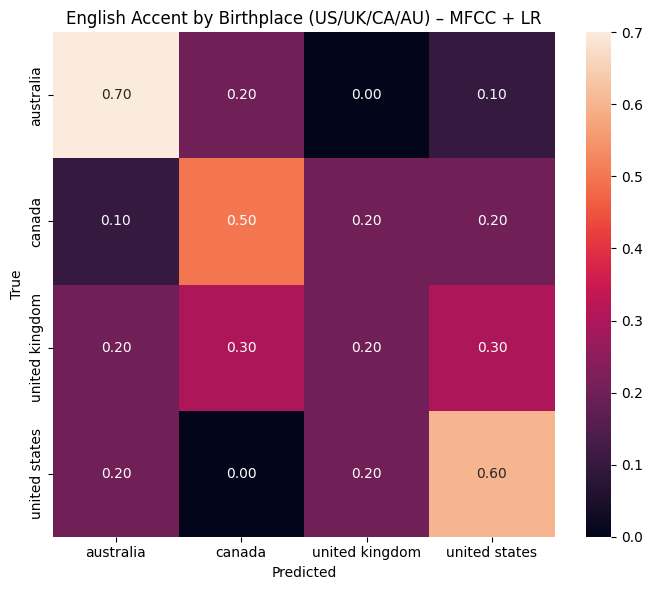

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(7,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("English Accent by Birthplace (US/UK/CA/AU) – MFCC + LR")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import f1_score

f1_macro = f1_score(y_test, y_pred, average="macro")
f1_micro = f1_score(y_test, y_pred, average="micro")
f1_weighted = f1_score(y_test, y_pred, average="weighted")

print(f"F1 Macro    (recommended): {f1_macro:.3f}")
print(f"F1 Micro    (same as accuracy): {f1_micro:.3f}")
print(f"F1 Weighted: {f1_weighted:.3f}")


F1 Macro    (recommended): 0.483
F1 Micro    (same as accuracy): 0.500
F1 Weighted: 0.483


In [ ]:
f1_svm = f1_score(y_test, y_pred_svm, average="macro")
print("SVM Macro F1:", f1_svm)


ValueError: Found input variables with inconsistent numbers of samples: [40, 60]

#new

##dload

In [ ]:
name="vladluca96"
key="KGAT_a6796e51d22cd80f8cd869b9e4618fee"

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os, pathlib
import pandas as pd

KAGGLE_USERNAME = name   # you already set this
KAGGLE_KEY = key

DATA_DIR = "/content/drive/MyDrive/accent_saa/data"
OUT_DIR  = "/content/drive/MyDrive/accent_saa/out"
pathlib.Path(DATA_DIR).mkdir(parents=True, exist_ok=True)
pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

META_PARQUET = os.path.join(OUT_DIR, "saa_meta.parquet")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip -q install kaggle

import os
os.environ["KAGGLE_USERNAME"] = KAGGLE_USERNAME
os.environ["KAGGLE_KEY"] = KAGGLE_KEY

KAGGLE_DATASET = "rtatman/speech-accent-archive"

# download + unzip only if not already there
!kaggle datasets download -d {KAGGLE_DATASET} -p {DATA_DIR} --unzip

!ls -lah {DATA_DIR}


Dataset URL: https://www.kaggle.com/datasets/rtatman/speech-accent-archive
License(s): CC-BY-NC-SA-4.0
 95% 825M/865M [00:03<00:00, 106MB/s]
100% 865M/865M [00:03<00:00, 293MB/s]
total 353K
drwx------ 2 root root 4.0K Jan 19 02:35 .ipynb_checkpoints
-rw------- 1 root root  354 Jan 19 02:39 reading-passage.txt
drwx------ 3 root root 4.0K Jan 19 02:26 recordings
-rw------- 1 root root 185K Jan 19 02:28 saa_meta.csv
-rw------- 1 root root 155K Jan 19 02:39 speakers_all.csv
drwx------ 3 root root 4.0K Jan 19 02:28 speech-accent-archive


In [ ]:
import os, glob

# locate speakers_all.csv
csv_hits = glob.glob(os.path.join(DATA_DIR, "**", "speakers_all.csv"), recursive=True)
assert csv_hits, "speakers_all.csv not found under DATA_DIR"
speakers_csv_path = csv_hits[0]
print("speakers_all.csv:", speakers_csv_path)

# find dir with the most audio files
audio_hits = glob.glob(os.path.join(DATA_DIR, "**", "*.mp3"), recursive=True) + \
             glob.glob(os.path.join(DATA_DIR, "**", "*.wav"), recursive=True)
assert audio_hits, "No .mp3/.wav found under DATA_DIR"

dir_counts = {}
for p in audio_hits:
    d = os.path.dirname(p)
    dir_counts[d] = dir_counts.get(d, 0) + 1

recordings_dir, n = sorted(dir_counts.items(), key=lambda x: x[1], reverse=True)[0]
print("recordings_dir:", recordings_dir, "| files:", n)
print("Example audio:", sorted(os.listdir(recordings_dir))[:10])


speakers_all.csv: /content/drive/MyDrive/accent_saa/data/speakers_all.csv
recordings_dir: /content/drive/MyDrive/accent_saa/data/recordings/recordings | files: 2138
Example audio: ['afrikaans1.mp3', 'afrikaans2.mp3', 'afrikaans3.mp3', 'afrikaans4.mp3', 'afrikaans5.mp3', 'agni1.mp3', 'akan1.mp3', 'albanian1.mp3', 'albanian2.mp3', 'albanian3.mp3']


In [ ]:
import pandas as pd, os

speakers_df = pd.read_csv(speakers_csv_path)
print("Columns:", speakers_df.columns.tolist())

LABEL_COL = "native_language"  # swap to "country" later if you want

df = speakers_df.copy()

# drop missing if present
if "file_missing?" in df.columns:
    df = df[~df["file_missing?"].astype(str).str.lower().isin(["true","1","yes"])].copy()

def get_audio_path(row):
    base = str(row["filename"]).strip()
    mp3 = os.path.join(recordings_dir, base + ".mp3")
    wav = os.path.join(recordings_dir, base + ".wav")
    if os.path.exists(mp3): return mp3
    if os.path.exists(wav): return wav
    return None

df["audio_path"] = df.apply(get_audio_path, axis=1)
df["label"] = df[LABEL_COL].astype(str).str.strip().str.lower()

df = df[df["audio_path"].notna()].copy()
df = df[df["label"].ne("") & df["label"].ne("nan")].copy()

meta = df[["audio_path","label","country","birthplace","sex","age","speakerid","filename"]].reset_index(drop=True)

MIN_SAMPLES = 40
counts = meta["label"].value_counts()
selected_labels = counts[counts >= MIN_SAMPLES].index.tolist()

meta_f = meta[meta["label"].isin(selected_labels)].copy().reset_index(drop=True)

print("Meta rows:", len(meta), "| Filtered rows:", len(meta_f))
print("Filtered label counts:\n", meta_f["label"].value_counts())

meta_f.to_parquet(META_PARQUET, index=False)
print("Saved:", META_PARQUET)


Columns: ['age', 'age_onset', 'birthplace', 'filename', 'native_language', 'sex', 'speakerid', 'country', 'file_missing?', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11']
Meta rows: 2138 | Filtered rows: 1166
Filtered label counts:
 label
english       579
spanish       162
arabic        102
mandarin       65
french         63
korean         52
portuguese     48
russian        48
dutch          47
Name: count, dtype: int64
Saved: /content/drive/MyDrive/accent_saa/out/saa_meta.parquet


In [ ]:
!pip -q uninstall -y kaggle || true
!pip -q install kaggle==1.5.16

!kaggle --version


  Preparing metadata (setup.py) ... done
Kaggle API 1.5.16


In [ ]:
name="vladluca96"
key="KGAT_a6796e51d22cd80f8cd869b9e4618fee"

from google.colab import drive
drive.mount("/content/drive")

import os, pathlib

os.environ["KAGGLE_USERNAME"] = name
os.environ["KAGGLE_KEY"] = key

BASE = "/content/drive/MyDrive/accent_datasets"
pathlib.Path(BASE).mkdir(parents=True, exist_ok=True)

print("BASE:", BASE)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BASE: /content/drive/MyDrive/accent_datasets


In [ ]:
!kaggle datasets list -s "L2-ARCTIC" | head -n 20


ref                                                              title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
tuhuutuong/l2-arctic                                             L2-arctic                                        768MB  2024-11-12 02:44:02             32          0  0.1875           
divyamagg/l2-arctic-data                                         L2 Arctic Data                                      0B  2024-03-27 16:31:48            264          1  0.0625           
davidthomastran/l2-arctic-embeddings-pca                         l2-arctic-embeddings-pca                         504MB  2025-11-16 17:53:55              0          0  0.23529412       
davidthomastran/l2-artic-en-mdd-with-nationality-catogorization  L2-AR

In [ ]:
import pathlib, os

KAGGLE_DATASET = "tuhuutuong/l2-arctic"   # <-- replace if your search shows a different one
DATA_DIR = f"{BASE}/l2_arctic/data"
OUT_DIR  = f"{BASE}/l2_arctic/out"

pathlib.Path(DATA_DIR).mkdir(parents=True, exist_ok=True)
pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

!kaggle datasets download -d {KAGGLE_DATASET} -p {DATA_DIR} --unzip

print("Top of DATA_DIR:")
!ls -lah {DATA_DIR} | head -n 50


 97% 746M/768M [00:05<00:00, 159MB/s]
100% 768M/768M [00:05<00:00, 145MB/s]
Top of DATA_DIR:
total 4.0K
drwx------ 5 root root 4.0K Jan 20 04:50 WAV


In [ ]:
import os, glob
import pandas as pd

# find audio
wav_hits = glob.glob(os.path.join(DATA_DIR, "**", "*.wav"), recursive=True)
assert wav_hits, "No .wav found under DATA_DIR. Check DATA_DIR and the Kaggle dataset slug."

print("Found wav:", len(wav_hits))
print("Example wav:", wav_hits[:5])

# L2-ARCTIC usually has speaker IDs as folder names, we infer label from speaker folder
def infer_speaker(path):
    # choose the first directory component under DATA_DIR as speaker id
    rel = os.path.relpath(path, DATA_DIR)
    parts = rel.split(os.sep)
    return parts[0].lower() if parts else "unknown"

manifest = pd.DataFrame({
    "audio_path": wav_hits,
})
manifest["speaker"] = manifest["audio_path"].map(infer_speaker)

MANIFEST_PARQUET = os.path.join(OUT_DIR, "l2_arctic_manifest.parquet")
MANIFEST_CSV     = os.path.join(OUT_DIR, "l2_arctic_manifest.csv")

manifest.to_parquet(MANIFEST_PARQUET, index=False)
manifest.to_csv(MANIFEST_CSV, index=False)

print("Saved:", MANIFEST_PARQUET)
print("Saved:", MANIFEST_CSV)
print(manifest["speaker"].value_counts().head(10))


Found wav: 9899
Example wav: ['/content/drive/MyDrive/accent_datasets/l2_arctic/data/WAV/L2_arctic_WAV/ABA_arctic_a0003.wav', '/content/drive/MyDrive/accent_datasets/l2_arctic/data/WAV/L2_arctic_WAV/ABA_arctic_a0005.wav', '/content/drive/MyDrive/accent_datasets/l2_arctic/data/WAV/L2_arctic_WAV/ABA_arctic_a0006.wav', '/content/drive/MyDrive/accent_datasets/l2_arctic/data/WAV/L2_arctic_WAV/ABA_arctic_a0007.wav', '/content/drive/MyDrive/accent_datasets/l2_arctic/data/WAV/L2_arctic_WAV/ABA_arctic_a0008.wav']
Saved: /content/drive/MyDrive/accent_datasets/l2_arctic/out/l2_arctic_manifest.parquet
Saved: /content/drive/MyDrive/accent_datasets/l2_arctic/out/l2_arctic_manifest.csv
speaker
wav    9899
Name: count, dtype: int64


In [ ]:
import os, glob, re
import pandas as pd

DATA_DIR = "/content/drive/MyDrive/accent_datasets/l2_arctic/data"
OUT_DIR  = "/content/drive/MyDrive/accent_datasets/l2_arctic/out"
os.makedirs(OUT_DIR, exist_ok=True)

wav_hits = glob.glob(os.path.join(DATA_DIR, "**", "*.wav"), recursive=True)
assert wav_hits, "No wav found."

def speaker_from_filename(path):
    base = os.path.basename(path)
    m = re.match(r"^([A-Z]{3})_arctic_.*\.wav$", base)
    if m:
        return m.group(1)
    # fallback: take token before first underscore
    return base.split("_")[0]

manifest = pd.DataFrame({"audio_path": wav_hits})
manifest["speaker"] = manifest["audio_path"].map(speaker_from_filename)

print("Speaker counts:\n", manifest["speaker"].value_counts().head(30))
print("Num speakers:", manifest["speaker"].nunique())

MANIFEST_PARQUET = os.path.join(OUT_DIR, "l2_arctic_manifest.parquet")
MANIFEST_CSV     = os.path.join(OUT_DIR, "l2_arctic_manifest.csv")
manifest.to_parquet(MANIFEST_PARQUET, index=False)
manifest.to_csv(MANIFEST_CSV, index=False)

print("Saved:", MANIFEST_PARQUET)


Speaker counts:
 speaker
sa1.wav      630
sa2.wav      630
LXC          150
MBMPS        150
NJS          150
NCC          150
PNV          150
HQTV         150
HKK          150
HJK          150
ERMS         150
EBVS         150
BWC          150
ASI          150
ABA          150
TLV          150
TNI          150
THV          150
TXHC         150
YDCK         150
YKWK         150
ZHAA         150
RRBI         150
SVBI         150
SKA          150
YBAA         149
sx54.wav       7
sx150.wav      7
sx414.wav      7
sx240.wav      7
Name: count, dtype: int64
Num speakers: 2366
Saved: /content/drive/MyDrive/accent_datasets/l2_arctic/out/l2_arctic_manifest.parquet


In [ ]:
import os, glob, re
import pandas as pd

DATA_DIR = "/content/drive/MyDrive/accent_datasets/l2_arctic/data"
OUT_DIR  = "/content/drive/MyDrive/accent_datasets/l2_arctic/out"
os.makedirs(OUT_DIR, exist_ok=True)

all_wavs = glob.glob(os.path.join(DATA_DIR, "**", "*.wav"), recursive=True)

pat = re.compile(r"^([A-Z]{3})_arctic_.*\.wav$")
kept = []
speakers = []

for p in all_wavs:
    base = os.path.basename(p)
    m = pat.match(base)
    if m:
        kept.append(p)
        speakers.append(m.group(1))

print("Total wavs found:", len(all_wavs))
print("L2-ARCTIC wavs kept:", len(kept))
print("Unique speakers:", len(set(speakers)))
print("Example kept:", kept[:5])
print("Speaker counts (top):")
print(pd.Series(speakers).value_counts().head(30))

manifest = pd.DataFrame({"audio_path": kept, "speaker": speakers})
MANIFEST_PARQUET = os.path.join(OUT_DIR, "l2_arctic_manifest.parquet")
MANIFEST_CSV     = os.path.join(OUT_DIR, "l2_arctic_manifest.csv")
manifest.to_parquet(MANIFEST_PARQUET, index=False)
manifest.to_csv(MANIFEST_CSV, index=False)

print("Saved:", MANIFEST_PARQUET)


Total wavs found: 9899
L2-ARCTIC wavs kept: 1950
Unique speakers: 13
Example kept: ['/content/drive/MyDrive/accent_datasets/l2_arctic/data/WAV/L2_arctic_WAV/ABA_arctic_a0003.wav', '/content/drive/MyDrive/accent_datasets/l2_arctic/data/WAV/L2_arctic_WAV/ABA_arctic_a0005.wav', '/content/drive/MyDrive/accent_datasets/l2_arctic/data/WAV/L2_arctic_WAV/ABA_arctic_a0006.wav', '/content/drive/MyDrive/accent_datasets/l2_arctic/data/WAV/L2_arctic_WAV/ABA_arctic_a0007.wav', '/content/drive/MyDrive/accent_datasets/l2_arctic/data/WAV/L2_arctic_WAV/ABA_arctic_a0008.wav']
Speaker counts (top):
ABA    150
ASI    150
BWC    150
HJK    150
HKK    150
LXC    150
NCC    150
NJS    150
PNV    150
SKA    150
THV    150
TLV    150
TNI    150
Name: count, dtype: int64
Saved: /content/drive/MyDrive/accent_datasets/l2_arctic/out/l2_arctic_manifest.parquet


In [ ]:
import os, pathlib, glob
import pandas as pd

BASE = "/content/drive/MyDrive/accent_datasets"
META_DIR = f"{BASE}/l2_arctic_nationality/data"
pathlib.Path(META_DIR).mkdir(parents=True, exist_ok=True)

KAGGLE_META = "davidthomastran/l2-artic-en-mdd-with-nationality-catogorization"
!kaggle datasets download -d {KAGGLE_META} -p {META_DIR} --unzip

print("Top of META_DIR:")
!ls -lah {META_DIR} | head -n 80


  0% 0.00/418k [00:00<?, ?B/s]
100% 418k/418k [00:00<00:00, 43.6MB/s]
Top of META_DIR:
total 8.0K
drwx------ 3 root root 4.0K Jan 20 05:19 graph_dataset_l2_artic
drwx------ 2 root root 4.0K Jan 20 05:20 graph_dataset_l2_artic_241_trans_41_canno


In [ ]:
import glob, pandas as pd, os

cand = glob.glob(os.path.join(META_DIR, "**", "*.csv"), recursive=True) + \
       glob.glob(os.path.join(META_DIR, "**", "*.tsv"), recursive=True)

print("Metadata candidates:", cand)
assert cand, "No CSV/TSV found in the nationality dataset. Show the META_DIR listing."

meta_path = cand[0]
print("Using:", meta_path)

if meta_path.endswith(".tsv"):
    meta_spk = pd.read_csv(meta_path, sep="\t")
else:
    meta_spk = pd.read_csv(meta_path)

print("Columns:", meta_spk.columns.tolist())
meta_spk.head()


Metadata candidates: ['/content/drive/MyDrive/accent_datasets/l2_arctic_nationality/data/graph_dataset_l2_artic/graph_dataset_l2_artic/dev.csv', '/content/drive/MyDrive/accent_datasets/l2_arctic_nationality/data/graph_dataset_l2_artic/graph_dataset_l2_artic/test.csv', '/content/drive/MyDrive/accent_datasets/l2_arctic_nationality/data/graph_dataset_l2_artic/graph_dataset_l2_artic/train.csv', '/content/drive/MyDrive/accent_datasets/l2_arctic_nationality/data/graph_dataset_l2_artic_241_trans_41_canno/dev_241_41.csv', '/content/drive/MyDrive/accent_datasets/l2_arctic_nationality/data/graph_dataset_l2_artic_241_trans_41_canno/test_241_41.csv', '/content/drive/MyDrive/accent_datasets/l2_arctic_nationality/data/graph_dataset_l2_artic_241_trans_41_canno/train_241_41.csv']
Using: /content/drive/MyDrive/accent_datasets/l2_arctic_nationality/data/graph_dataset_l2_artic/graph_dataset_l2_artic/dev.csv
Columns: ['Path', 'Canonical', 'Transcript']


Path  \
0  L2_arctic_WAV/EBVS_arctic_a0094   
1  L2_arctic_WAV/EBVS_arctic_a0556   
2  L2_arctic_WAV/EBVS_arctic_a0198   
3  L2_arctic_WAV/EBVS_arctic_b0019   
4  L2_arctic_WAV/EBVS_arctic_a0106   

                                           Canonical  \
0  hh_S iy_S hh_S ae_S d_S b_S eh_S r_S l_S iy_S ...   
1  hh_S w_S ay_S hh_S iy_S z_S b_S ao_S t_S f_S a...   
2  s_S ah_S m_S t_S ay_S m_S z_S hh_S er_S d_S r_...   
3  hh_S ih_S z_S s_S l_S ih_S m_S hh_S ae_S n_S d...   
4  dh_S ah_S ih_S m_S ow_S sh_S ah_S n_S w_S ih_S...   

                                          Transcript  
0  hh_S iy_S hh_S aa_S d_S b_S aa_S r_S l_S iy_S ...  
1  hh_S w_S ay_S hh_S iy_S s_S b_S ow_S f_S ao_S ...  
2  s_S ah_S m_S t_S ay_S m_S s_S er_S d_S r_S iy_...  
3  s_S l_S iy_S m_S aa_S n_S s_S g_S r_S iy_S p_S...  
4  d_S ah_S ih_S m_S ow_S sh_S ah_S ng_S w_S iy_S...

In [ ]:
import pandas as pd

manifest = pd.read_parquet("/content/drive/MyDrive/accent_datasets/l2_arctic/out/l2_arctic_manifest.parquet")

# normalize columns
meta_spk.columns = [c.strip().lower() for c in meta_spk.columns]
manifest["speaker"] = manifest["speaker"].astype(str).str.upper().str.strip()

# guess speaker column
speaker_col = None
for c in ["speaker", "spk", "spkid", "speaker_id", "id"]:
    if c in meta_spk.columns:
        speaker_col = c
        break
assert speaker_col is not None, f"Could not find speaker column. Columns: {meta_spk.columns.tolist()}"

# guess label column
label_col = None
for c in ["l1", "native_language", "nationality", "country", "accent"]:
    if c in meta_spk.columns:
        label_col = c
        break
assert label_col is not None, f"Could not find label column. Columns: {meta_spk.columns.tolist()}"

meta_spk[speaker_col] = meta_spk[speaker_col].astype(str).str.upper().str.strip()
meta_spk["label"] = meta_spk[label_col].astype(str).str.lower().str.strip()

df = manifest.merge(meta_spk[[speaker_col, "label"]], left_on="speaker", right_on=speaker_col, how="inner")
df = df.drop(columns=[speaker_col])

print("Rows after merge:", len(df))
print("Label counts:\n", df["label"].value_counts())
df.head()


AssertionError: Could not find speaker column. Columns: ['path', 'canonical', 'transcript']

###arctic

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

!apt-get -qq update
!apt-get -qq install -y p7zip-full unrar tar gzip bzip2 xz-utils


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
import os
from pathlib import Path

# Path to the TOP archive you uploaded to Drive
ARCHIVE_PATH = "/content/drive/MyDrive/l2arctic_release_v5.0.zip"   # <-- change

# Where to extract everything
OUT_DIR = "/content/drive/MyDrive/accent_datasets/l2_arctic_official_extracted"  # <-- change

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

print("ARCHIVE_PATH:", ARCHIVE_PATH)
print("OUT_DIR:", OUT_DIR)
assert os.path.exists(ARCHIVE_PATH), "ARCHIVE_PATH does not exist. Fix the path."


ARCHIVE_PATH: /content/drive/MyDrive/l2arctic_release_v5.0.zip
OUT_DIR: /content/drive/MyDrive/accent_datasets/l2_arctic_official_extracted


In [ ]:
import os, re, shutil, subprocess
from pathlib import Path
import tarfile, zipfile, gzip

ARCHIVE_EXTS = (
    ".zip", ".tar", ".tgz", ".tar.gz", ".tar.bz2", ".tbz2", ".tar.xz", ".txz",
    ".7z", ".rar", ".gz"
)

def is_archive(p: str) -> bool:
    p = p.lower()
    return any(p.endswith(ext) for ext in ARCHIVE_EXTS)

def safe_join(base: str, *paths: str) -> str:
    # prevent path traversal
    base = os.path.abspath(base)
    out = os.path.abspath(os.path.join(base, *paths))
    if not out.startswith(base + os.sep) and out != base:
        raise RuntimeError(f"Path traversal detected: {out}")
    return out

def safe_extract_zip(zip_path: str, out_dir: str):
    with zipfile.ZipFile(zip_path, "r") as z:
        for m in z.infolist():
            # check traversal
            safe_join(out_dir, m.filename)
        z.extractall(out_dir)

def safe_extract_tar(tar_path: str, out_dir: str):
    with tarfile.open(tar_path, "r:*") as t:
        for m in t.getmembers():
            safe_join(out_dir, m.name)
        t.extractall(out_dir)

def extract_gz_single(gz_path: str, out_dir: str):
    # only for single-file .gz (not .tar.gz which tarfile handles)
    out_name = Path(gz_path).name[:-3]
    out_path = os.path.join(out_dir, out_name)
    if os.path.exists(out_path) and os.path.getsize(out_path) > 0:
        return out_path
    with gzip.open(gz_path, "rb") as fin, open(out_path, "wb") as fout:
        shutil.copyfileobj(fin, fout)
    return out_path

def extract_any(archive_path: str, out_dir: str):
    ap = archive_path
    low = ap.lower()

    Path(out_dir).mkdir(parents=True, exist_ok=True)

    # zip
    if low.endswith(".zip"):
        safe_extract_zip(ap, out_dir)
        return

    # tar variants
    if low.endswith(".tar") or low.endswith(".tgz") or low.endswith(".tar.gz") or low.endswith(".tar.bz2") or low.endswith(".tbz2") or low.endswith(".tar.xz") or low.endswith(".txz"):
        safe_extract_tar(ap, out_dir)
        return

    # plain .gz (single file)
    if low.endswith(".gz") and (not low.endswith(".tar.gz")):
        extract_gz_single(ap, out_dir)
        return

    # 7z / rar via 7z
    if low.endswith(".7z") or low.endswith(".rar"):
        # -y yes, -o output
        subprocess.check_call(["7z", "x", "-y", f"-o{out_dir}", ap])
        return

    raise ValueError(f"Unsupported archive type: {archive_path}")

def find_archives(root_dir: str):
    hits = []
    for r, _, files in os.walk(root_dir):
        for f in files:
            p = os.path.join(r, f)
            if is_archive(p):
                hits.append(p)
    return hits

def extract_recursively(top_archive: str, final_out: str, max_rounds: int = 50, remove_archives: bool = False):
    # 1) extract the top archive into final_out
    print(f"[1] Extract top: {top_archive}")
    extract_any(top_archive, final_out)

    # 2) repeatedly find nested archives and extract them next to themselves
    for round_i in range(1, max_rounds + 1):
        archives = find_archives(final_out)
        if not archives:
            print(f"[done] No more nested archives after {round_i-1} rounds.")
            return

        print(f"[round {round_i}] Found {len(archives)} nested archives")
        extracted_any = False

        for ap in archives:
            # extract into a folder named after the archive file
            stem = Path(ap).name
            # clean a bit (optional)
            stem = re.sub(r"\.(zip|tar|tgz|tar\.gz|tar\.bz2|tbz2|tar\.xz|txz|7z|rar|gz)$", "", stem, flags=re.IGNORECASE)
            out_dir = os.path.join(os.path.dirname(ap), stem)

            # skip if it looks already extracted (folder exists + non-empty)
            if os.path.isdir(out_dir) and any(Path(out_dir).iterdir()):
                continue

            try:
                extract_any(ap, out_dir)
                extracted_any = True
                if remove_archives:
                    os.remove(ap)
                print("  extracted:", ap, "->", out_dir)
            except Exception as e:
                print("  [warn] failed:", ap, "|", repr(e))

        if not extracted_any:
            print("[stop] Archives found but none extracted (maybe already extracted or unsupported).")
            return

# Run it
extract_recursively(ARCHIVE_PATH, OUT_DIR, max_rounds=50, remove_archives=False)

print("\nTop-level of OUT_DIR:")
!ls -lah "{OUT_DIR}" | head -n 80


[1] Extract top: /content/drive/MyDrive/l2arctic_release_v5.0.zip
[round 1] Found 25 nested archives
  extracted: /content/drive/MyDrive/accent_datasets/l2_arctic_official_extracted/ABA.zip -> /content/drive/MyDrive/accent_datasets/l2_arctic_official_extracted/ABA
  extracted: /content/drive/MyDrive/accent_datasets/l2_arctic_official_extracted/ASI.zip -> /content/drive/MyDrive/accent_datasets/l2_arctic_official_extracted/ASI
  extracted: /content/drive/MyDrive/accent_datasets/l2_arctic_official_extracted/BWC.zip -> /content/drive/MyDrive/accent_datasets/l2_arctic_official_extracted/BWC
  extracted: /content/drive/MyDrive/accent_datasets/l2_arctic_official_extracted/EBVS.zip -> /content/drive/MyDrive/accent_datasets/l2_arctic_official_extracted/EBVS
  extracted: /content/drive/MyDrive/accent_datasets/l2_arctic_official_extracted/ERMS.zip -> /content/drive/MyDrive/accent_datasets/l2_arctic_official_extracted/ERMS
  extracted: /content/drive/MyDrive/accent_datasets/l2_arctic_official_extr

##mfcc

In [ ]:
!pip -q install librosa soundfile tqdm numpy pyarrow


In [ ]:

import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa
import os

meta_f = pd.read_parquet(META_PARQUET)

MFCC_DIR = os.path.join(OUT_DIR, "features_mfcc")
os.makedirs(MFCC_DIR, exist_ok=True)

MFCC_NPZ = os.path.join(MFCC_DIR, "mfcc_features.npz")
MFCC_INDEX = os.path.join(MFCC_DIR, "mfcc_index.csv")

SR = 16000
N_MFCC = 20
HOP_LENGTH = 160
N_FFT = 400

def extract_mfcc_vec(path):
    y, sr = librosa.load(path, sr=SR, mono=True)
    mfcc = librosa.feature.mfcc(y=y, sr=SR, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
    d1 = librosa.feature.delta(mfcc)
    d2 = librosa.feature.delta(mfcc, order=2)
    feat = np.concatenate([mfcc, d1, d2], axis=0)
    return np.concatenate([feat.mean(axis=1), feat.std(axis=1)], axis=0).astype(np.float32)

X, y, paths = [], [], []
for r in tqdm(meta_f.itertuples(index=False), total=len(meta_f)):
    try:
        X.append(extract_mfcc_vec(r.audio_path))
        y.append(r.label)
        paths.append(r.audio_path)
    except Exception:
        continue

assert len(X) > 0, "No MFCC vectors extracted (check audio paths)."

X = np.stack(X, axis=0)
y = np.array(y)

np.savez_compressed(MFCC_NPZ, X=X, y=y)
pd.DataFrame({"audio_path": paths, "label": y}).to_csv(MFCC_INDEX, index=False)

print("MFCC shape:", X.shape)
print("Saved:", MFCC_NPZ)


100%|██████████| 1166/1166 [02:15<00:00,  8.58it/s]

MFCC shape: (1166, 120)
Saved: /content/drive/MyDrive/accent_saa/out/features_mfcc/mfcc_features.npz


##wav2vec

In [ ]:
!pip -q install transformers accelerate torch librosa soundfile tqdm


In [ ]:

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import librosa
from transformers import AutoProcessor, AutoModel

meta_f = pd.read_parquet(META_PARQUET)

W2V_DIR = os.path.join(OUT_DIR, "features_wav2vec")
os.makedirs(W2V_DIR, exist_ok=True)

W2V_NPZ   = os.path.join(W2V_DIR, "wav2vec_embeddings.npz")
W2V_INDEX = os.path.join(W2V_DIR, "wav2vec_index.csv")
W2V_ERRS  = os.path.join(W2V_DIR, "wav2vec_errors.txt")

MODEL_NAME = "facebook/wav2vec2-base-960h"
TARGET_SR = 16000
MAX_SECONDS = 12.0

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

processor = AutoProcessor.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(device)
model.eval()

@torch.no_grad()
def extract_w2v_vec(path):
    y, sr = librosa.load(path, sr=TARGET_SR, mono=True)  # decodes mp3
    max_len = int(TARGET_SR * MAX_SECONDS)
    if y.shape[0] > max_len:
        y = y[:max_len]

    inputs = processor(y, sampling_rate=TARGET_SR, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    out = model(**inputs).last_hidden_state  # [1, T, H]
    return out.mean(dim=1).squeeze(0).detach().cpu().numpy().astype(np.float32)

X, y, paths = [], [], []
errors = []

for r in tqdm(meta_f.itertuples(index=False), total=len(meta_f)):
    try:
        X.append(extract_w2v_vec(r.audio_path))
        y.append(r.label)
        paths.append(r.audio_path)
    except Exception as e:
        errors.append((r.audio_path, repr(e)))

print("Extracted:", len(X), "| Errors:", len(errors))

with open(W2V_ERRS, "w") as f:
    for p, e in errors[:2000]:
        f.write(f"{p}\t{e}\n")

assert len(X) > 0, f"Zero embeddings extracted. Check {W2V_ERRS}."

X = np.stack(X, axis=0)
y = np.array(y)

np.savez_compressed(W2V_NPZ, X=X, y=y)
pd.DataFrame({"audio_path": paths, "label": y}).to_csv(W2V_INDEX, index=False)

print("Wav2Vec shape:", X.shape)
print("Saved:", W2V_NPZ)
print("Saved:", W2V_INDEX)


Device: cuda


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1166/1166 [01:07<00:00, 17.29it/s]


Extracted: 1166 | Errors: 0
Wav2Vec shape: (1166, 768)
Saved: /content/drive/MyDrive/accent_saa/out/features_wav2vec/wav2vec_embeddings.npz
Saved: /content/drive/MyDrive/accent_saa/out/features_wav2vec/wav2vec_index.csv


In [ ]:
import numpy as np, pandas as pd, os

mf = np.load(os.path.join(OUT_DIR, "features_mfcc", "mfcc_features.npz"), allow_pickle=True)
w2 = np.load(os.path.join(OUT_DIR, "features_wav2vec", "wav2vec_embeddings.npz"), allow_pickle=True)

print("MFCC X:", mf["X"].shape, "labels:", pd.Series(mf["y"]).value_counts().head(10).to_dict())
print("W2V  X:", w2["X"].shape, "labels:", pd.Series(w2["y"]).value_counts().head(10).to_dict())


MFCC X: (1166, 120) labels: {'english': 579, 'spanish': 162, 'arabic': 102, 'mandarin': 65, 'french': 63, 'korean': 52, 'portuguese': 48, 'russian': 48, 'dutch': 47}
W2V  X: (1166, 768) labels: {'english': 579, 'spanish': 162, 'arabic': 102, 'mandarin': 65, 'french': 63, 'korean': 52, 'portuguese': 48, 'russian': 48, 'dutch': 47}


##class

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load
mf = np.load(os.path.join(OUT_DIR, "features_mfcc", "mfcc_features.npz"), allow_pickle=True)
w2 = np.load(os.path.join(OUT_DIR, "features_wav2vec", "wav2vec_embeddings.npz"), allow_pickle=True)
fb = np.load(os.path.join(OUT_DIR, "features_facebook_hubert-large-ls960-ft", "embeddings.npz"), allow_pickle=True)

X_mfcc = mf["X"]
y_raw  = mf["y"]

X_w2v  = w2["X"]
X_fb  = fb["X"]


# Encode labels
le = LabelEncoder()
y = le.fit_transform(y_raw)

print("Classes:", dict(zip(le.classes_, range(len(le.classes_)))))
print("X_mfcc:", X_mfcc.shape, "X_w2v:", X_w2v.shape, "y:", y.shape)

# Stratified split
Xmf_tr, Xmf_te, y_tr, y_te = train_test_split(
    X_mfcc, y, test_size=0.25, random_state=42, stratify=y
)

Xw2_tr, Xw2_te, _, _ = train_test_split(
    X_w2v, y, test_size=0.25, random_state=42, stratify=y
)

Xfb_tr, Xfb_te, _, _ = train_test_split(
    X_fb, y, test_size=0.25, random_state=42, stratify=y
)


Classes: {np.str_('arabic'): 0, np.str_('dutch'): 1, np.str_('english'): 2, np.str_('french'): 3, np.str_('korean'): 4, np.str_('mandarin'): 5, np.str_('portuguese'): 6, np.str_('russian'): 7, np.str_('spanish'): 8}
X_mfcc: (1166, 120) X_w2v: (1166, 768) y: (1166,)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

def run_logreg(Xtr, Xte, ytr, yte, name):
    clf = LogisticRegression(
        max_iter=3000,
        n_jobs=-1,
        class_weight="balanced"
    )
    clf.fit(Xtr, ytr)
    yp = clf.predict(Xte)

    acc = accuracy_score(yte, yp)
    f1  = f1_score(yte, yp, average="macro")

    print(f"[{name}]  acc={acc:.4f}  macro-F1={f1:.4f}")

run_logreg(Xmf_tr, Xmf_te, y_tr, y_te, "MFCC + LogReg")
run_logreg(Xw2_tr, Xw2_te, y_tr, y_te, "W2V  + LogReg")
run_logreg(Xfb_tr, Xfb_te, y_tr, y_te, "FB  + LogReg")



[MFCC + LogReg]  acc=0.2774  macro-F1=0.1860
[W2V  + LogReg]  acc=0.5411  macro-F1=0.3880
[FB  + LogReg]  acc=0.6507  macro-F1=0.4964


In [ ]:
from sklearn.svm import LinearSVC

def run_svm(Xtr, Xte, ytr, yte, name):
    clf = LinearSVC(
        class_weight="balanced",
        max_iter=8000
    )
    clf.fit(Xtr, ytr)
    yp = clf.predict(Xte)

    acc = accuracy_score(yte, yp)
    f1  = f1_score(yte, yp, average="macro")

    print(f"[{name}]  acc={acc:.4f}  macro-F1={f1:.4f}")

run_svm(Xmf_tr, Xmf_te, y_tr, y_te, "MFCC + SVM")
run_svm(Xw2_tr, Xw2_te, y_tr, y_te, "W2V  + SVM")
run_svm(Xfb_tr, Xfb_te, y_tr, y_te, "FB  + SVM")


[MFCC + SVM]  acc=0.4110  macro-F1=0.2369
[W2V  + SVM]  acc=0.6164  macro-F1=0.4151
[FB  + SVM]  acc=0.8014  macro-F1=0.6749


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score

def run_mlp(Xtr, Xte, ytr, yte, name):
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            hidden_layer_sizes=(256, 128),
            activation="relu",
            alpha=1e-4,
            batch_size=128,
            learning_rate_init=1e-3,
            max_iter=40,
            early_stopping=True,
            random_state=42
        ))
    ])
    clf.fit(Xtr, ytr)
    yp = clf.predict(Xte)
    acc = accuracy_score(yte, yp)
    f1  = f1_score(yte, yp, average="macro")
    print(f"[{name}]  acc={acc:.4f}  macro-F1={f1:.4f}")

run_mlp(Xmf_tr, Xmf_te, y_tr, y_te, "MFCC + MLP")
run_mlp(Xw2_tr, Xw2_te, y_tr, y_te, "W2V  + MLP")
run_mlp(Xfb_tr, Xfb_te, y_tr, y_te, "FB  + MLP")


[MFCC + MLP]  acc=0.4966  macro-F1=0.0737
[W2V  + MLP]  acc=0.6062  macro-F1=0.3215
[FB  + MLP]  acc=0.6815  macro-F1=0.3915


In [ ]:
from transformers import AutoProcessor, AutoModel
import torch, librosa, numpy as np
from tqdm import tqdm
import pandas as pd, os

meta_f = pd.read_parquet(META_PARQUET)

# Try one of these:
# MODEL_NAME = "microsoft/wavlm-large"
MODEL_NAME = "facebook/hubert-large-ls960-ft"
# MODEL_NAME = "facebook/wav2vec2-large-xlsr-53"

TARGET_SR = 16000
MAX_SECONDS = 12.0
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

processor = AutoProcessor.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(device)
model.eval()

@torch.no_grad()
def extract_ssl_vec(path):
    y, sr = librosa.load(path, sr=TARGET_SR, mono=True)
    max_len = int(TARGET_SR * MAX_SECONDS)
    if y.shape[0] > max_len:
        y = y[:max_len]
    inputs = processor(y, sampling_rate=TARGET_SR, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    out = model(**inputs).last_hidden_state
    emb = out.mean(dim=1).squeeze(0).detach().cpu().numpy().astype(np.float32)
    return emb

X_big, y_big, paths_big = [], [], []
for r in tqdm(meta_f.itertuples(index=False), total=len(meta_f)):
    try:
        X_big.append(extract_ssl_vec(r.audio_path))
        y_big.append(r.label)
        paths_big.append(r.audio_path)
    except Exception:
        continue

X_big = np.stack(X_big, axis=0)
y_big = np.array(y_big)

print("Big SSL embeddings:", X_big.shape, "labels:", len(y_big))

# Save
BIG_DIR = os.path.join(OUT_DIR, f"features_{MODEL_NAME.replace('/','_')}")
os.makedirs(BIG_DIR, exist_ok=True)
np.savez_compressed(os.path.join(BIG_DIR, "embeddings.npz"), X=X_big, y=y_big)
pd.DataFrame({"audio_path": paths_big, "label": y_big}).to_csv(os.path.join(BIG_DIR, "index.csv"), index=False)

print("Saved to:", BIG_DIR)


Device: cuda


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]


100%|██████████| 1166/1166 [01:29<00:00, 13.01it/s]


Big SSL embeddings: (1166, 1024) labels: 1166
Saved to: /content/drive/MyDrive/accent_saa/out/features_facebook_hubert-large-ls960-ft


In [ ]:
!pip -q install transformers datasets accelerate evaluate librosa soundfile torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# paths (edit if needed)
OUT_DIR = "/content/drive/MyDrive/accent_saa/out"
META_PARQUET = os.path.join(OUT_DIR, "saa_meta.parquet")

meta = pd.read_parquet(META_PARQUET)
meta = meta[meta["audio_path"].map(os.path.exists)].copy()

# keep only the labels you already used (>=40 samples) if you want reproducibility
# (if your parquet already contains filtered rows, this does nothing harmful)
MIN_SAMPLES = 40
vc = meta["label"].value_counts()
keep = vc[vc >= MIN_SAMPLES].index.tolist()
meta = meta[meta["label"].isin(keep)].reset_index(drop=True)

print("Rows:", len(meta))
print(meta["label"].value_counts())

# encode labels
le = LabelEncoder()
meta["label_id"] = le.fit_transform(meta["label"].astype(str))
num_labels = len(le.classes_)
print("Num labels:", num_labels)
print("Label mapping:", dict(zip(le.classes_, range(num_labels))))

# stratified split
train_df, test_df = train_test_split(
    meta, test_size=0.25, random_state=42, stratify=meta["label_id"]
)
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

print("Train:", len(train_df), "Test:", len(test_df))


Rows: 1166
label
english       579
spanish       162
arabic        102
mandarin       65
french         63
korean         52
portuguese     48
russian        48
dutch          47
Name: count, dtype: int64
Num labels: 9
Label mapping: {'arabic': 0, 'dutch': 1, 'english': 2, 'french': 3, 'korean': 4, 'mandarin': 5, 'portuguese': 6, 'russian': 7, 'spanish': 8}
Train: 874 Test: 292


In [ ]:
from datasets import Dataset
import librosa

TARGET_SR = 16000
MAX_SECONDS = 6.0  # keep it smaller for faster fine-tuning; bump to 12.0 later if you want

def load_audio(batch):
    path = batch["audio_path"]
    y, sr = librosa.load(path, sr=TARGET_SR, mono=True)
    max_len = int(TARGET_SR * MAX_SECONDS)
    if y.shape[0] > max_len:
        y = y[:max_len]
    batch["speech"] = y
    batch["sampling_rate"] = TARGET_SR
    return batch

train_ds = Dataset.from_pandas(train_df[["audio_path","label","label_id"]])
test_ds  = Dataset.from_pandas(test_df[["audio_path","label","label_id"]])

train_ds = train_ds.map(load_audio, num_proc=1)
test_ds  = test_ds.map(load_audio, num_proc=1)

train_ds


Map:   0%|          | 0/874 [00:00<?, ? examples/s]

Map:   0%|          | 0/292 [00:00<?, ? examples/s]

Dataset({
    features: ['audio_path', 'label', 'label_id', 'speech', 'sampling_rate'],
    num_rows: 874
})

In [ ]:
from transformers import AutoProcessor

MODEL_NAME = "facebook/wav2vec2-base-960h"

processor = AutoProcessor.from_pretrained(MODEL_NAME)

def preprocess(batch):
    inputs = processor(
        batch["speech"],
        sampling_rate=batch["sampling_rate"],
        return_tensors="np",
        padding=False
    )
    batch["input_values"] = inputs["input_values"][0]  # 1D float array
    batch["labels"] = int(batch["label_id"])
    return batch

train_ds = train_ds.map(preprocess, remove_columns=train_ds.column_names, num_proc=1)
test_ds  = test_ds.map(preprocess, remove_columns=test_ds.column_names, num_proc=1)

train_ds[0].keys()


Map:   0%|          | 0/874 [00:00<?, ? examples/s]

Map:   0%|          | 0/292 [00:00<?, ? examples/s]

dict_keys(['input_values', 'labels'])

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(
    tokenizer=processor,   # <-- NOT processor=
    padding=True
)


In [ ]:
import torch
from transformers import AutoModelForAudioClassification

id2label = {i: lbl for i, lbl in enumerate(le.classes_)}
label2id = {lbl: i for i, lbl in id2label.items()}

model = AutoModelForAudioClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

# optional: freeze feature encoder for faster/stabler fine-tuning on small data
# good idea for your dataset size; you can also compare freeze vs unfreeze later
model.freeze_feature_encoder()

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print("Device:", device)


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: cuda


In [ ]:
import evaluate
from transformers import TrainingArguments, Trainer

acc_metric = evaluate.load("accuracy")
f1_metric  = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = acc_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1  = f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]
    return {"accuracy": acc, "macro_f1": f1}

training_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "w2v2_cls_ckpt"),

    # OLD API name in your version:
    eval_strategy="epoch",
    save_strategy="epoch",

    logging_strategy="steps",
    logging_steps=50,

    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=6,
    warmup_ratio=0.1,
    weight_decay=0.01,

    fp16=True,
    load_best_model_at_end=True,

    metric_for_best_model="macro_f1",
    greater_is_better=True,

    report_to="none"
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=data_collator,
    tokenizer=processor,
    compute_metrics=compute_metrics,
)

trainer.train()


/tmp/ipython-input-4172862027.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


TrainOutput(global_step=660, training_loss=0.0, metrics={'train_runtime': 352.5655, 'train_samples_per_second': 14.874, 'train_steps_per_second': 1.872, 'total_flos': 2.85655531343616e+17, 'train_loss': 0.0, 'epoch': 6.0})

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

pred = trainer.predict(test_ds)
logits = pred.predictions
y_true = pred.label_ids
y_pred = np.argmax(logits, axis=-1)

print("Classification report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_, digits=4))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix:\n", cm)


Classification report:

              precision    recall  f1-score   support

      arabic     0.0000    0.0000    0.0000        25
       dutch     0.0000    0.0000    0.0000        12
     english     0.0000    0.0000    0.0000       145
      french     0.0000    0.0000    0.0000        16
      korean     0.0000    0.0000    0.0000        13
    mandarin     0.0000    0.0000    0.0000        16
  portuguese     0.0418    1.0000    0.0803        12
     russian     0.0000    0.0000    0.0000        12
     spanish     0.0000    0.0000    0.0000        41

    accuracy                         0.0411       292
   macro avg     0.0046    0.1111    0.0089       292
weighted avg     0.0017    0.0411    0.0033       292


Confusion matrix:
 [[  0   0   0   0   0   0  25   0   0]
 [  0   0   0   0   0   0  11   1   0]
 [  0   0   0   0   0   0 141   4   0]
 [  0   0   0   0   0   0  16   0   0]
 [  0   0   0   0   0   0  13   0   0]
 [  0   0   0   0   0   0  16   0   0]
 [  0   0   0   0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
print("Train item keys:", train_ds[0].keys())
print("len(input_values):", len(train_ds[0]["input_values"]))
print("labels:", train_ds[0]["labels"], type(train_ds[0]["labels"]))

# check label range
labs = [train_ds[i]["labels"] for i in range(min(50, len(train_ds)))]
print("Min label:", min(labs), "Max label:", max(labs), "Num labels:", num_labels)

# check lengths vary
lens = [len(train_ds[i]["input_values"]) for i in range(10)]
print("First 10 lengths:", lens)
print("Any empty?", any(l == 0 for l in lens))


Train item keys: dict_keys(['input_values', 'labels'])
len(input_values): 96000
labels: 2 <class 'int'>
Min label: 0 Max label: 8 Num labels: 9
First 10 lengths: [96000, 96000, 96000, 96000, 96000, 96000, 96000, 96000, 96000, 96000]
Any empty? False


In [ ]:
from transformers import DataCollatorCTCWithPadding

data_collator = DataCollatorCTCWithPadding(
    processor=processor,
    padding=True
)


ImportError: cannot import name 'DataCollatorCTCWithPadding' from 'transformers' (/usr/local/lib/python3.12/dist-packages/transformers/__init__.py)

#arctic class

##feat

In [5]:
!pip -q install librosa soundfile tqdm pandas numpy pyarrow transformers accelerate torch

import os, re, glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa
import torch
from transformers import AutoProcessor, AutoModel


In [6]:
from google.colab import drive
drive.mount("/content/drive")

DATA_ROOT = "/content/drive/MyDrive/accent_datasets/l2_arctic_official_extracted"   # <-- change if different
OUT_DIR   = "/content/drive/MyDrive/accent_datasets/l2_arctic_official/out"  # <-- change if you want

os.makedirs(OUT_DIR, exist_ok=True)

META_PARQUET = os.path.join(OUT_DIR, "l2_arctic_meta.parquet")
META_CSV     = os.path.join(OUT_DIR, "l2_arctic_meta.csv")

print("DATA_ROOT:", DATA_ROOT)
print("OUT_DIR:", OUT_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DATA_ROOT: /content/drive/MyDrive/accent_datasets/l2_arctic_official_extracted
OUT_DIR: /content/drive/MyDrive/accent_datasets/l2_arctic_official/out


In [7]:
SPEAKER_INFO = [
    ("ABA",  "Arabic",     "M"),
    ("SKA",  "Arabic",     "F"),
    ("YBAA", "Arabic",     "M"),
    ("ZHAA", "Arabic",     "F"),

    ("BWC",  "Mandarin",   "M"),
    ("LXC",  "Mandarin",   "F"),
    ("NCC",  "Mandarin",   "F"),
    ("TXHC", "Mandarin",   "M"),

    ("ASI",  "Hindi",      "M"),
    ("RRBI", "Hindi",      "M"),
    ("SVBI", "Hindi",      "F"),
    ("TNI",  "Hindi",      "F"),

    ("HJK",  "Korean",     "F"),
    ("HKK",  "Korean",     "M"),
    ("YDCK", "Korean",     "F"),
    ("YKWK", "Korean",     "M"),

    ("EBVS", "Spanish",    "M"),
    ("ERMS", "Spanish",    "M"),
    ("MBMPS","Spanish",    "F"),
    ("NJS",  "Spanish",    "F"),

    ("HQTV", "Vietnamese", "M"),
    ("PNV",  "Vietnamese", "F"),
    ("THV",  "Vietnamese", "F"),
    ("TLV",  "Vietnamese", "M"),
]

spk2l1 = {s: l1 for s, l1, g in SPEAKER_INFO}
spk2g  = {s: g  for s, l1, g in SPEAKER_INFO}

print("Speakers:", len(spk2l1), "L1 classes:", sorted(set(spk2l1.values())))


Speakers: 24 L1 classes: ['Arabic', 'Hindi', 'Korean', 'Mandarin', 'Spanish', 'Vietnamese']


In [ ]:
import os, glob
import pandas as pd

# DATA_ROOT must point to the folder that contains ABA/, ASI/, ...
# OUT_DIR, META_PARQUET, META_CSV already defined
# spk2l1, spk2g already defined

wav_paths = glob.glob(os.path.join(DATA_ROOT, "**", "wav", "*.wav"), recursive=True)
assert wav_paths, "No wav files found. Check DATA_ROOT."

rows = []
unknown_speakers = set()
bad_paths = []

for p in wav_paths:
    # normalize
    p = os.path.normpath(p)
    parts = p.split(os.sep)

    # find the "wav" folder index
    try:
        wav_idx = len(parts) - 2  # .../wav/file.wav -> wav is -2
        if parts[wav_idx].lower() != "wav":
            # fallback: search for 'wav' anywhere
            wav_idx = next(i for i,x in enumerate(parts) if x.lower() == "wav")
    except Exception:
        bad_paths.append(p)
        continue

    # speaker is expected to be the folder just before 'wav' (your <SPK>)
    # .../<SPK>/wav/<file>
    if wav_idx - 1 < 0:
        bad_paths.append(p)
        continue

    spk = parts[wav_idx - 1].upper()

    # sometimes you have .../<SPK>/<SPK>/wav/...
    # in that case spk is the inner folder, which is correct.
    l1 = spk2l1.get(spk)
    g  = spk2g.get(spk)

    if l1 is None:
        unknown_speakers.add(spk)
        continue

    rows.append((p, spk, l1, g))

meta = pd.DataFrame(rows, columns=["audio_path", "speaker", "l1", "gender"])
meta["label"] = meta["l1"].astype(str).str.lower().str.strip()

print("Total wavs on disk:", len(wav_paths))
print("Kept (speaker in table):", len(meta))
print("Unknown speakers:", sorted(list(unknown_speakers))[:50])
print("Bad paths:", len(bad_paths))

print("\nLabel counts:\n", meta["label"].value_counts())
print("\nSpeaker counts:\n", meta["speaker"].value_counts())

meta.to_parquet(META_PARQUET, index=False)
meta.to_csv(META_CSV, index=False)
print("\nSaved:", META_PARQUET)
print("Saved:", META_CSV)

# show a few rows to sanity-check
meta.sample(5, random_state=0)


Total wavs on disk: 26889
Kept (speaker in table): 26867
Unknown speakers: ['SUITCASE_CORPUS']
Bad paths: 0

Label counts:
 label
vietnamese    4528
hindi         4524
korean        4524
mandarin      4524
spanish       4402
arabic        4365
Name: count, dtype: int64

Speaker counts:
 speaker
HQTV     1132
ERMS     1132
TXHC     1132
ZHAA     1132
THV      1132
SVBI     1132
PNV      1132
MBMPS    1132
TLV      1132
YDCK     1131
TNI      1131
HKK      1131
HJK      1131
ASI      1131
NCC      1131
LXC      1131
YKWK     1131
NJS      1131
BWC      1130
RRBI     1130
YBAA     1130
ABA      1129
EBVS     1007
SKA       974
Name: count, dtype: int64

Saved: /content/drive/MyDrive/accent_datasets/l2_arctic_official/out/l2_arctic_meta.parquet
Saved: /content/drive/MyDrive/accent_datasets/l2_arctic_official/out/l2_arctic_meta.csv


audio_path speaker          l1  \
8172   /content/drive/MyDrive/accent_datasets/l2_arct...    HQTV  Vietnamese   
7274   /content/drive/MyDrive/accent_datasets/l2_arct...     HKK      Korean   
4853   /content/drive/MyDrive/accent_datasets/l2_arct...    ERMS     Spanish   
17773  /content/drive/MyDrive/accent_datasets/l2_arct...    SVBI       Hindi   
807    /content/drive/MyDrive/accent_datasets/l2_arct...     ABA      Arabic   

      gender       label  
8172       M  vietnamese  
7274       M      korean  
4853       M     spanish  
17773      F       hindi  
807        M      arabic

In [ ]:
meta_f = pd.read_parquet(META_PARQUET)

MFCC_DIR = os.path.join(OUT_DIR, "features_mfcc")
os.makedirs(MFCC_DIR, exist_ok=True)

MFCC_NPZ   = os.path.join(MFCC_DIR, "mfcc_features.npz")
MFCC_INDEX = os.path.join(MFCC_DIR, "mfcc_index.csv")
MFCC_ERRS  = os.path.join(MFCC_DIR, "mfcc_errors.txt")

SR = 16000
N_MFCC = 20
HOP_LENGTH = 160
N_FFT = 400

def extract_mfcc_vec(path):
    y, sr = librosa.load(path, sr=SR, mono=True)
    mfcc = librosa.feature.mfcc(y=y, sr=SR, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
    d1 = librosa.feature.delta(mfcc)
    d2 = librosa.feature.delta(mfcc, order=2)
    feat = np.concatenate([mfcc, d1, d2], axis=0)
    return np.concatenate([feat.mean(axis=1), feat.std(axis=1)], axis=0).astype(np.float32)

def _process_row(r):
    # r is a tuple from itertuples(index=False)
    try:
        return (extract_mfcc_vec(r.audio_path), r.label, r.audio_path, None)
    except Exception as e:
        return (None, None, None, (r.audio_path, repr(e)))

X, y, paths = [], [], []
errors = []

from concurrent.futures import ThreadPoolExecutor, as_completed
import os

rows = list(meta_f.itertuples(index=False))
max_workers = min(32, (os.cpu_count() or 2) * 2)

with ThreadPoolExecutor(max_workers=max_workers) as ex:
    futures = [ex.submit(_process_row, r) for r in rows]
    for fut in tqdm(as_completed(futures), total=len(futures)):
        x_i, y_i, p_i, err = fut.result()
        if err is not None:
            errors.append(err)
        else:
            X.append(x_i)
            y.append(y_i)
            paths.append(p_i)

print("Extracted:", len(X), "| Errors:", len(errors))

with open(MFCC_ERRS, "w") as f:
    for p, e in errors[:5000]:
        f.write(f"{p}\t{e}\n")

assert len(X) > 0, f"No MFCC vectors extracted. Check {MFCC_ERRS}."

X = np.stack(X, axis=0)
y = np.array(y)

np.savez_compressed(MFCC_NPZ, X=X, y=y)
pd.DataFrame({"audio_path": paths, "label": y}).to_csv(MFCC_INDEX, index=False)

print("MFCC shape:", X.shape)
print("Saved:", MFCC_NPZ)
print("Saved:", MFCC_INDEX)


100%|██████████| 26867/26867 [13:07<00:00, 34.12it/s]


Extracted: 26867 | Errors: 0
MFCC shape: (26867, 120)
Saved: /content/drive/MyDrive/accent_datasets/l2_arctic_official/out/features_mfcc/mfcc_features.npz
Saved: /content/drive/MyDrive/accent_datasets/l2_arctic_official/out/features_mfcc/mfcc_index.csv


In [ ]:
meta_f = pd.read_parquet(META_PARQUET)

TARGET_SR = 16000
MAX_SECONDS = 12.0  # crop for compute

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

def extract_ssl_embeddings(
    model_name: str,
    out_subdir: str,
    meta_f: pd.DataFrame,
    max_seconds: float = 12.0,
    target_sr: int = 16000,
):
    OUT = os.path.join(OUT_DIR, out_subdir)
    os.makedirs(OUT, exist_ok=True)

    NPZ   = os.path.join(OUT, "embeddings.npz")
    INDEX = os.path.join(OUT, "index.csv")
    ERRS  = os.path.join(OUT, "errors.txt")

    processor = AutoProcessor.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    model.eval()

    @torch.no_grad()
    def extract_vec(path: str) -> np.ndarray:
        y, sr = librosa.load(path, sr=target_sr, mono=True)
        max_len = int(target_sr * max_seconds)
        if y.shape[0] > max_len:
            y = y[:max_len]

        inputs = processor(y, sampling_rate=target_sr, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        out = model(**inputs).last_hidden_state  # [1, T, H]
        emb = out.mean(dim=1).squeeze(0).detach().cpu().numpy().astype(np.float32)
        return emb

    X, ylab, paths = [], [], []
    errors = []

    for r in tqdm(meta_f.itertuples(index=False), total=len(meta_f)):
        try:
            X.append(extract_vec(r.audio_path))
            ylab.append(r.label)
            paths.append(r.audio_path)
        except Exception as e:
            errors.append((r.audio_path, repr(e)))

    print(f"[{model_name}] Extracted:", len(X), "| Errors:", len(errors))

    with open(ERRS, "w") as f:
        for p, e in errors[:5000]:
            f.write(f"{p}\t{e}\n")

    assert len(X) > 0, f"Zero embeddings extracted for {model_name}. Check {ERRS}."

    X = np.stack(X, axis=0)
    ylab = np.array(ylab)

    np.savez_compressed(NPZ, X=X, y=ylab)
    pd.DataFrame({"audio_path": paths, "label": ylab}).to_csv(INDEX, index=False)

    print("Embeddings shape:", X.shape)
    print("Saved:", NPZ)
    print("Saved:", INDEX)

    return NPZ, INDEX, ERRS


Device: cuda


In [6]:
import os
import numpy as np
import pandas as pd
import torch
import librosa
import torchaudio
import soundfile as sf
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

from transformers import AutoProcessor, AutoModel

meta_f = pd.read_parquet(META_PARQUET)

TARGET_SR = 16000
MAX_SECONDS = 12.0  # crop for compute

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

def extract_ssl_embeddings(
    model_name: str,
    out_subdir: str,
    meta_f: pd.DataFrame,
    max_seconds: float = 12.0,
    target_sr: int = 16000,
):
    OUT = os.path.join(OUT_DIR, out_subdir)
    os.makedirs(OUT, exist_ok=True)

    NPZ   = os.path.join(OUT, "embeddings.npz")
    INDEX = os.path.join(OUT, "index.csv")
    ERRS  = os.path.join(OUT, "errors.txt")

    processor = AutoProcessor.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    model.eval()

    # -------- performance knobs (A100) --------
    BATCH_SIZE  = 270   # huBERT-large + 12s can be heavy; try 32, then 16 if OOM
    NUM_WORKERS = 8    # try 8-16
    USE_AMP     = (device == "cuda")
    AMP_DTYPE   = torch.float16
    # -----------------------------------------

    @torch.no_grad()
    def _load_and_crop(path: str) -> np.ndarray:
        max_len = int(target_sr * max_seconds)

        # 1) Fast path: torchaudio (may fail if no backend/codec for the file type)
        try:
            wav, sr = torchaudio.load(path)      # [C, N]
            wav = wav.mean(dim=0)                # mono
            if sr != target_sr:
                wav = torchaudio.functional.resample(wav, sr, target_sr)
            if wav.numel() > max_len:
                wav = wav[:max_len]
            return wav.numpy()
        except Exception:
            pass

        # 2) soundfile: good for wav/flac/ogg depending on build
        try:
            y, sr = sf.read(path, dtype="float32", always_2d=False)
            if y.ndim > 1:
                y = y.mean(axis=1)  # to mono
            if sr != target_sr:
                y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
            if y.shape[0] > max_len:
                y = y[:max_len]
            return y.astype(np.float32)
        except Exception:
            pass

        # 3) librosa: slowest but decodes many formats via audioread
        y, sr = librosa.load(path, sr=target_sr, mono=True)
        if y.shape[0] > max_len:
            y = y[:max_len]
        return y.astype(np.float32)

    @torch.no_grad()
    def _forward_batch(wavs_np):
        inputs = processor(
            wavs_np,
            sampling_rate=target_sr,
            return_tensors="pt",
            padding=True,
            return_attention_mask=True,
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.autocast(device_type="cuda", dtype=AMP_DTYPE, enabled=USE_AMP):
            outputs = model(**inputs)
            out = outputs.last_hidden_state  # [B, T, H]

        # Downsample the *sample-level* attention mask to *frame-level*
        if "attention_mask" in inputs:
            feat_mask = model._get_feature_vector_attention_mask(
                out.shape[1],  # T
                inputs["attention_mask"]
            )  # [B, T]
            feat_mask = feat_mask.unsqueeze(-1).type_as(out)  # [B, T, 1]

            emb = (out * feat_mask).sum(dim=1) / feat_mask.sum(dim=1).clamp(min=1.0)
        else:
            emb = out.mean(dim=1)

        return emb.detach().cpu().numpy().astype(np.float32)


    X, ylab, paths = [], [], []
    errors = []

    rows = list(meta_f.itertuples(index=False))
    i = 0

    with ThreadPoolExecutor(max_workers=NUM_WORKERS) as pool:
        with tqdm(total=len(rows)) as pbar:
            while i < len(rows):
                batch_rows = rows[i : i + BATCH_SIZE]
                batch_paths = [r.audio_path for r in batch_rows]

                try:
                    wavs = list(pool.map(_load_and_crop, batch_paths))
                    batch_embs = _forward_batch(wavs)

                    for r, emb in zip(batch_rows, batch_embs):
                        X.append(emb)
                        ylab.append(r.label)
                        paths.append(r.audio_path)

                except Exception as e_batch:
                    # fall back per item to preserve your original behavior
                    for r in batch_rows:
                        try:
                            wav = _load_and_crop(r.audio_path)
                            emb = _forward_batch([wav])[0]
                            X.append(emb)
                            ylab.append(r.label)
                            paths.append(r.audio_path)
                        except Exception as e:
                            errors.append((r.audio_path, repr(e)))

                i += len(batch_rows)
                pbar.update(len(batch_rows))

    print(f"[{model_name}] Extracted:", len(X), "| Errors:", len(errors))

    # write errors (first 5000 like before)
    with open(ERRS, "w") as f:
        for p, e in errors[:5000]:
            f.write(f"{p}\t{e}\n")

    assert len(X) > 0, f"Zero embeddings extracted for {model_name}. Check {ERRS}."

    X = np.stack(X, axis=0)
    ylab = np.array(ylab)

    np.savez_compressed(NPZ, X=X, y=ylab)
    pd.DataFrame({"audio_path": paths, "label": ylab}).to_csv(INDEX, index=False)

    print("Embeddings shape:", X.shape)
    print("Saved:", NPZ)
    print("Saved:", INDEX)

    return NPZ, INDEX, ERRS


Device: cuda


In [ ]:
extract_ssl_embeddings(
    model_name="facebook/wav2vec2-base-960h",
    out_subdir="features_facebook_wav2vec2-base-960h",
    meta_f=meta_f,
    max_seconds=12.0,
    target_sr=16000,
)


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 26867/26867 [38:17<00:00, 11.69it/s]


[facebook/wav2vec2-base-960h] Extracted: 26867 | Errors: 0
Embeddings shape: (26867, 768)
Saved: /content/drive/MyDrive/accent_datasets/l2_arctic_official/out/features_facebook_wav2vec2-base-960h/embeddings.npz
Saved: /content/drive/MyDrive/accent_datasets/l2_arctic_official/out/features_facebook_wav2vec2-base-960h/index.csv


('/content/drive/MyDrive/accent_datasets/l2_arctic_official/out/features_facebook_wav2vec2-base-960h/embeddings.npz',
 '/content/drive/MyDrive/accent_datasets/l2_arctic_official/out/features_facebook_wav2vec2-base-960h/index.csv',
 '/content/drive/MyDrive/accent_datasets/l2_arctic_official/out/features_facebook_wav2vec2-base-960h/errors.txt')

In [7]:
extract_ssl_embeddings(
    model_name="facebook/hubert-large-ls960-ft",
    out_subdir="features_facebook_hubert-large-ls960-ft",
    meta_f=meta_f,
    max_seconds=12.0,
    target_sr=16000,
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
100%|██████████| 26867/26867 [03:39<00:00, 122.33it/s]


[facebook/hubert-large-ls960-ft] Extracted: 26867 | Errors: 0
Embeddings shape: (26867, 1024)
Saved: /content/drive/MyDrive/accent_datasets/l2_arctic_official/out/features_facebook_hubert-large-ls960-ft/embeddings.npz
Saved: /content/drive/MyDrive/accent_datasets/l2_arctic_official/out/features_facebook_hubert-large-ls960-ft/index.csv


('/content/drive/MyDrive/accent_datasets/l2_arctic_official/out/features_facebook_hubert-large-ls960-ft/embeddings.npz',
 '/content/drive/MyDrive/accent_datasets/l2_arctic_official/out/features_facebook_hubert-large-ls960-ft/index.csv',
 '/content/drive/MyDrive/accent_datasets/l2_arctic_official/out/features_facebook_hubert-large-ls960-ft/errors.txt')

##class

In [1]:
import numpy as np
import pandas as pd
import os

OUT_DIR = "/content/drive/MyDrive/accent_datasets/l2_arctic_official/out"

MFCC_NPZ   = os.path.join(OUT_DIR, "features_mfcc/mfcc_features.npz")
MFCC_INDEX = os.path.join(OUT_DIR, "features_mfcc/mfcc_index.csv")

W2V_NPZ    = os.path.join(OUT_DIR, "features_facebook_wav2vec2-base-960h/embeddings.npz")
W2V_INDEX  = os.path.join(OUT_DIR, "features_facebook_wav2vec2-base-960h/index.csv")

HUB_NPZ    = os.path.join(OUT_DIR, "features_facebook_hubert-large-ls960-ft/embeddings.npz")
HUB_INDEX  = os.path.join(OUT_DIR, "features_facebook_hubert-large-ls960-ft/index.csv")

META_PARQUET = os.path.join(OUT_DIR, "l2_arctic_meta.parquet")

meta = pd.read_parquet(META_PARQUET)

mfcc = np.load(MFCC_NPZ)
w2v  = np.load(W2V_NPZ)
hub  = np.load(HUB_NPZ)

mfcc_index = pd.read_csv(MFCC_INDEX)
w2v_index  = pd.read_csv(W2V_INDEX)
hub_index  = pd.read_csv(HUB_INDEX)

# Align metadata to feature order
meta_mfcc = meta.merge(mfcc_index, on=["audio_path","label"], how="inner")
meta_w2v  = meta.merge(w2v_index,  on=["audio_path","label"], how="inner")
meta_hub  = meta.merge(hub_index,  on=["audio_path","label"], how="inner")

# Sanity: make sure ordering is identical
assert meta_mfcc["audio_path"].equals(meta_w2v["audio_path"])
assert meta_mfcc["audio_path"].equals(meta_hub["audio_path"])

X_mfcc = mfcc["X"]
X_w2v  = w2v["X"]
X_hub  = hub["X"]

y = mfcc["y"]
speakers = meta_mfcc["speaker"].values

print("Shapes:")
print("MFCC :", X_mfcc.shape)
print("W2V2 :", X_w2v.shape)
print("HuBERT:", X_hub.shape)


Shapes:
MFCC : (26867, 120)
W2V2 : (26867, 768)
HuBERT: (26867, 1024)


In [2]:
import numpy as np

rng = np.random.default_rng(42)

labels = meta_mfcc["label"].values
unique_l1 = np.unique(labels)

test_speakers = []

for l1 in unique_l1:
    spks = meta_mfcc.loc[labels == l1, "speaker"].unique()
    test_speakers.append(rng.choice(spks))

test_speakers = set(test_speakers)
print("Test speakers:", test_speakers)

is_test = np.array([s in test_speakers for s in speakers])
train_idx = np.where(~is_test)[0]
test_idx  = np.where(is_test)[0]

print("Train samples:", len(train_idx))
print("Test samples:", len(test_idx))


Test speakers: {'YDCK', 'TNI', 'ERMS', 'ABA', 'LXC', 'TLV'}
Train samples: 20081
Test samples: 6786


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

def run_clf(X, y, train_idx, test_idx, clf, name):
    Xtr, Xte = X[train_idx], X[test_idx]
    ytr, yte = y[train_idx], y[test_idx]

    clf.fit(Xtr, ytr)
    yp = clf.predict(Xte)

    acc = accuracy_score(yte, yp)
    f1  = f1_score(yte, yp, average="macro")

    print(f"[{name}] acc={acc:.4f}  macro-F1={f1:.4f}")
    return acc, f1


In [11]:
print("=== MFCC ===")

run_clf(
    X_mfcc, y, train_idx, test_idx,
    make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000)),
    "MFCC + LogReg"
)

run_clf(
    X_mfcc, y, train_idx, test_idx,
    make_pipeline(StandardScaler(), SVC(kernel="rbf")),
    "MFCC + SVM"
)

run_clf(
    X_mfcc, y, train_idx, test_idx,
    make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(256,128), max_iter=200)),
    "MFCC + MLP"
)


=== MFCC ===
[MFCC + LogReg] acc=0.1938  macro-F1=0.1486
[MFCC + SVM] acc=0.1665  macro-F1=0.1241
[MFCC + MLP] acc=0.1773  macro-F1=0.1324


(0.17727674624226347, 0.13244838668939227)

In [12]:
print("\n=== Wav2Vec2 ===")

run_clf(
    X_w2v, y, train_idx, test_idx,
    make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000)),
    "W2V2 + LogReg"
)

run_clf(
    X_w2v, y, train_idx, test_idx,
    make_pipeline(StandardScaler(), SVC(kernel="rbf")),
    "W2V2 + SVM"
)

run_clf(
    X_w2v, y, train_idx, test_idx,
    make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(256,128), max_iter=200)),
    "W2V2 + MLP"
)



=== Wav2Vec2 ===
[W2V2 + LogReg] acc=0.3565  macro-F1=0.3547
[W2V2 + SVM] acc=0.3677  macro-F1=0.3663
[W2V2 + MLP] acc=0.3419  macro-F1=0.3411


(0.3418803418803419, 0.34107406500940396)

In [13]:
print("\n=== HuBERT-large ===")

run_clf(
    X_hub, y, train_idx, test_idx,
    make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000)),
    "HuBERT + LogReg"
)

run_clf(
    X_hub, y, train_idx, test_idx,
    make_pipeline(StandardScaler(), SVC(kernel="rbf")),
    "HuBERT + SVM"
)

run_clf(
    X_hub, y, train_idx, test_idx,
    make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(256,128), max_iter=200)),
    "HuBERT + MLP"
)



=== HuBERT-large ===
[HuBERT + LogReg] acc=0.6177  macro-F1=0.6088
[HuBERT + SVM] acc=0.6235  macro-F1=0.6167
[HuBERT + MLP] acc=0.6208  macro-F1=0.6099


(0.6208370173887415, 0.6099448048907982)

In [14]:
results = []

def run_and_store(X, name_prefix):
    for clf_name, clf in [
        ("LogReg", make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000))),
        ("SVM",    make_pipeline(StandardScaler(), SVC(kernel="rbf"))),
        ("MLP",    make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(256,128), max_iter=200))),
    ]:
        acc, f1 = run_clf(X, y, train_idx, test_idx, clf, f"{name_prefix} + {clf_name}")
        results.append((name_prefix, clf_name, acc, f1))

run_and_store(X_mfcc, "MFCC")
run_and_store(X_w2v,  "W2V2")
run_and_store(X_hub,  "HuBERT")

res_df = pd.DataFrame(results, columns=["features","model","acc","macro_f1"])
res_df.sort_values("macro_f1", ascending=False)


[MFCC + LogReg] acc=0.1938  macro-F1=0.1486
[MFCC + SVM] acc=0.1665  macro-F1=0.1241
[MFCC + MLP] acc=0.1860  macro-F1=0.1335


KeyboardInterrupt: 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

def plot_cm(X, y, train_idx, test_idx, clf, title="", normalize=None):
    """
    normalize: None | 'true' | 'pred' | 'all'
      - 'true' gives per-row normalized (recall-like), best for "where does each class go"
    """
    Xtr, Xte = X[train_idx], X[test_idx]
    ytr, yte = y[train_idx], y[test_idx]

    clf.fit(Xtr, ytr)
    yp = clf.predict(Xte)

    labels = np.unique(np.concatenate([yte, yp]))
    cm = confusion_matrix(yte, yp, labels=labels, normalize=normalize)

    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation=45, values_format=".2f" if normalize else "d")
    ax.set_title(title + (f" | normalize={normalize}" if normalize else ""))
    plt.tight_layout()
    plt.show()

    print("Classification report:")
    print(classification_report(yte, yp, digits=4))
    return yp


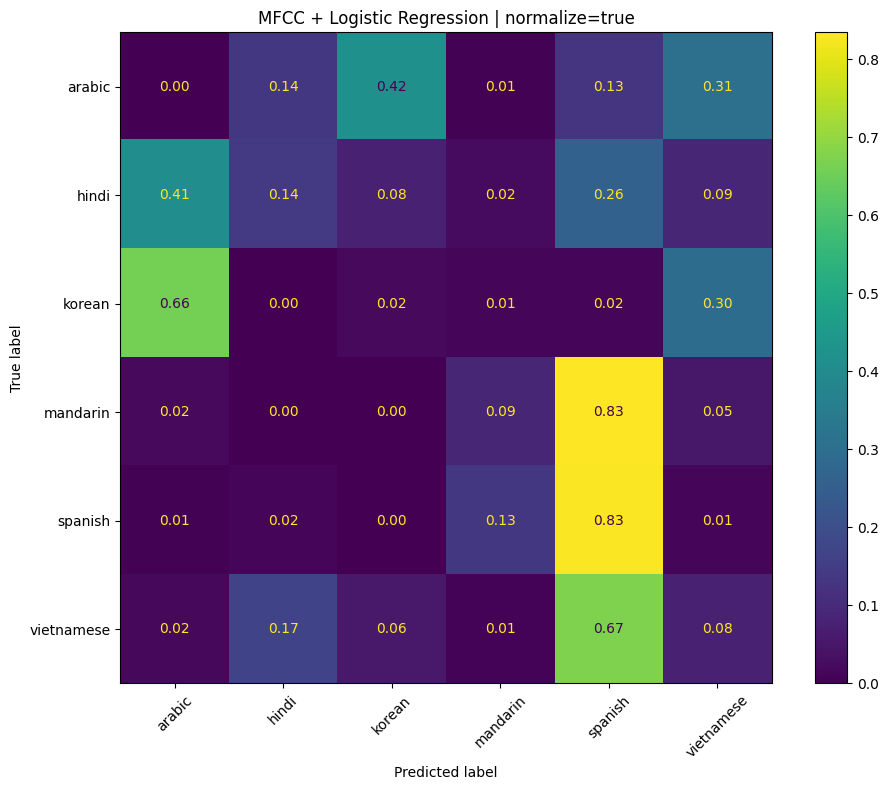

Classification report:
              precision    recall  f1-score   support

      arabic     0.0024    0.0027    0.0025      1128
       hindi     0.3098    0.1431    0.1958      1132
      korean     0.0352    0.0203    0.0258      1132
    mandarin     0.3257    0.0884    0.1391      1131
     spanish     0.3034    0.8311    0.4445      1131
  vietnamese     0.0921    0.0769    0.0838      1132

    accuracy                         0.1938      6786
   macro avg     0.1781    0.1937    0.1486      6786
weighted avg     0.1782    0.1938    0.1486      6786



In [12]:
clf_mfcc_logreg = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=3000)
)

_ = plot_cm(
    X_mfcc, y, train_idx, test_idx,
    clf_mfcc_logreg,
    title="MFCC + Logistic Regression",
    normalize="true"   # <-- recommended (row-normalized)
)


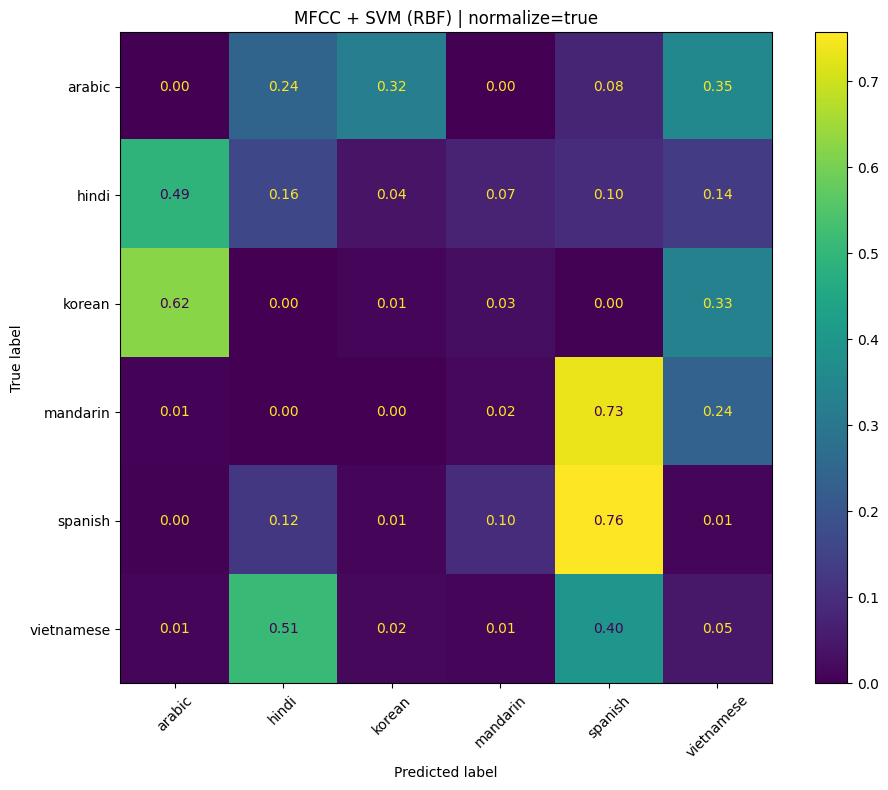

Classification report:
              precision    recall  f1-score   support

      arabic     0.0008    0.0009    0.0008      1128
       hindi     0.1578    0.1643    0.1610      1132
      korean     0.0263    0.0106    0.0151      1132
    mandarin     0.0739    0.0168    0.0274      1131
     spanish     0.3664    0.7569    0.4938      1131
  vietnamese     0.0442    0.0495    0.0467      1132

    accuracy                         0.1665      6786
   macro avg     0.1116    0.1665    0.1241      6786
weighted avg     0.1116    0.1665    0.1242      6786



In [13]:
clf_mfcc_svm = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf")
)

_ = plot_cm(
    X_mfcc, y, train_idx, test_idx,
    clf_mfcc_svm,
    title="MFCC + SVM (RBF)",
    normalize="true"
)


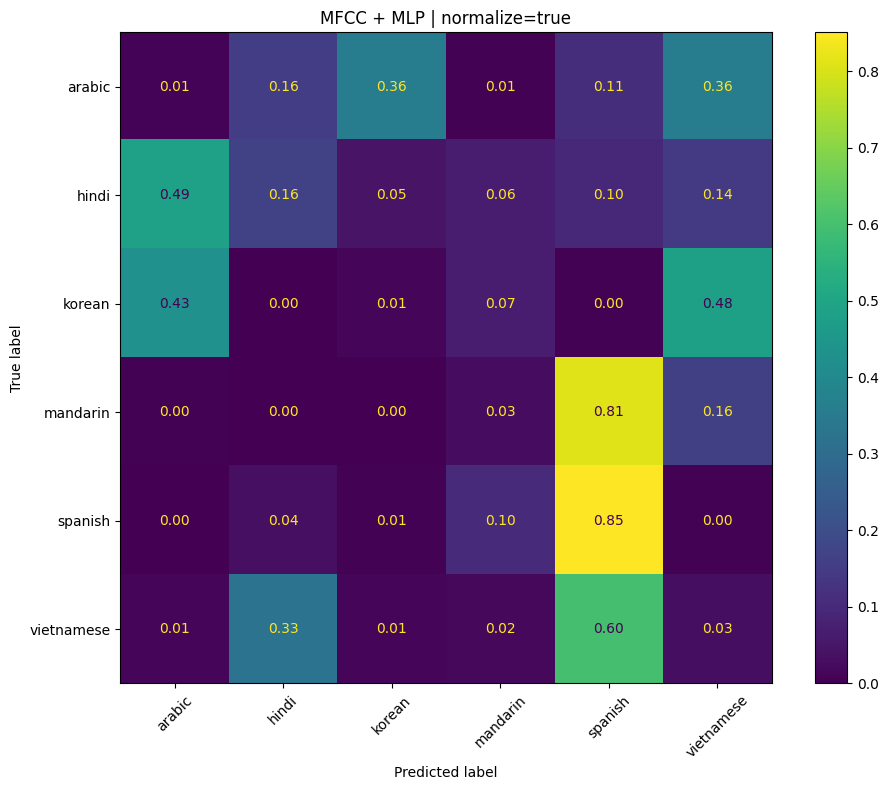

Classification report:
              precision    recall  f1-score   support

      arabic     0.0103    0.0098    0.0100      1128
       hindi     0.2399    0.1634    0.1944      1132
      korean     0.0324    0.0141    0.0197      1132
    mandarin     0.0969    0.0274    0.0427      1131
     spanish     0.3441    0.8506    0.4899      1131
  vietnamese     0.0254    0.0300    0.0276      1132

    accuracy                         0.1826      6786
   macro avg     0.1248    0.1826    0.1307      6786
weighted avg     0.1249    0.1826    0.1308      6786



In [14]:
clf_mfcc_mlp = make_pipeline(
    StandardScaler(),
    MLPClassifier(hidden_layer_sizes=(256,128), max_iter=400, random_state=42)
)

_ = plot_cm(
    X_mfcc, y, train_idx, test_idx,
    clf_mfcc_mlp,
    title="MFCC + MLP",
    normalize="true"
)


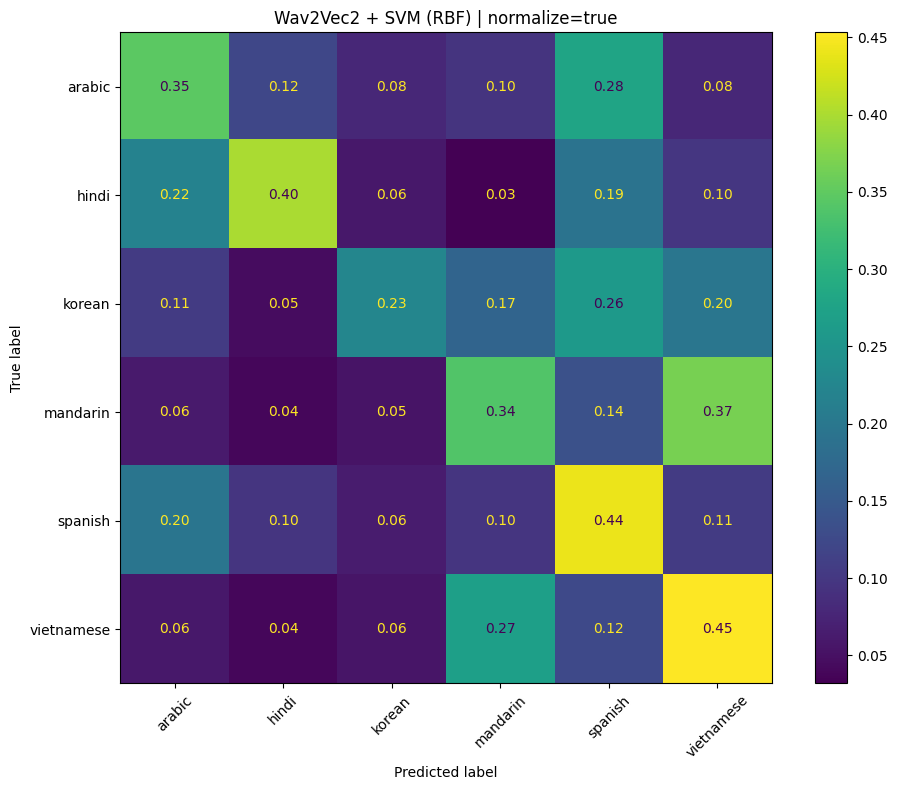

Classification report:
              precision    recall  f1-score   support

      arabic     0.3506    0.3475    0.3491      1128
       hindi     0.5393    0.4002    0.4594      1132
      korean     0.4194    0.2253    0.2931      1132
    mandarin     0.3395    0.3395    0.3395      1131
     spanish     0.3076    0.4403    0.3622      1131
  vietnamese     0.3490    0.4532    0.3943      1132

    accuracy                         0.3677      6786
   macro avg     0.3842    0.3677    0.3663      6786
weighted avg     0.3843    0.3677    0.3663      6786



In [15]:
# --- Wav2Vec2 + SVM confusion matrix ---

clf_w2v_svm = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf")
)

_ = plot_cm(
    X_w2v, y, train_idx, test_idx,
    clf_w2v_svm,
    title="Wav2Vec2 + SVM (RBF)",
    normalize="true"   # row-normalized = recall per class
)


In [16]:
HUBERT_NPZ = os.path.join(
    OUT_DIR,
    "features_facebook_hubert-large-ls960-ft",
    "embeddings.npz"
)

hubert = np.load(HUBERT_NPZ)
X_hubert = hubert["X"]


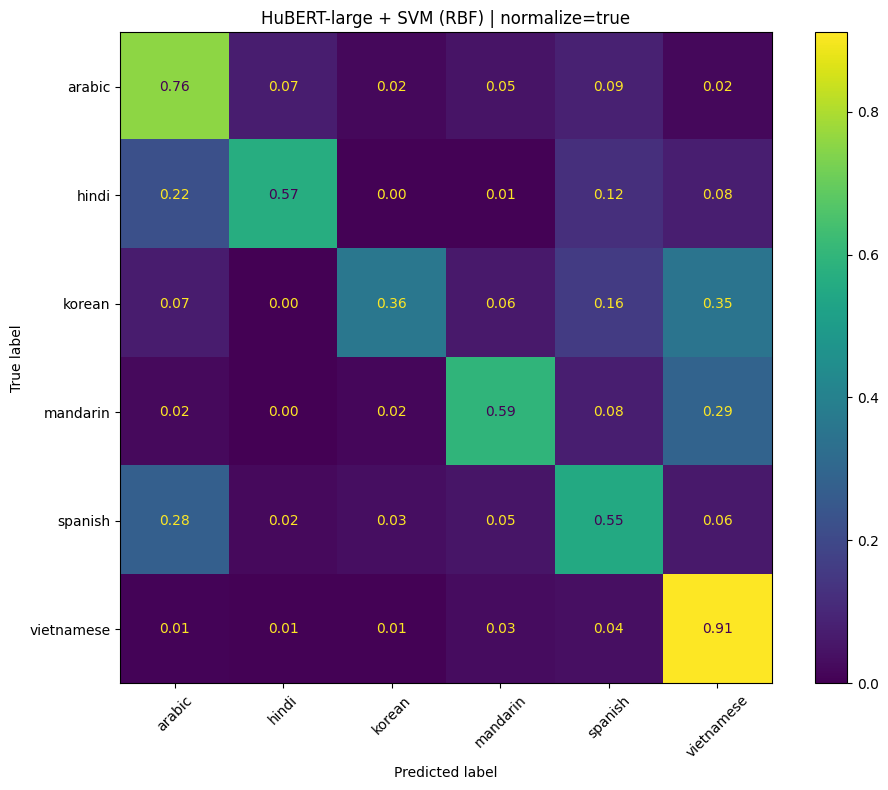

Classification report:
              precision    recall  f1-score   support

      arabic     0.5553    0.7562    0.6404      1128
       hindi     0.8440    0.5689    0.6797      1132
      korean     0.8189    0.3595    0.4997      1132
    mandarin     0.7534    0.5942    0.6644      1131
     spanish     0.5342    0.5517    0.5428      1131
  vietnamese     0.5342    0.9108    0.6734      1132

    accuracy                         0.6235      6786
   macro avg     0.6733    0.6236    0.6167      6786
weighted avg     0.6734    0.6235    0.6167      6786



In [17]:
# --- HuBERT-large + SVM confusion matrix ---

clf_hubert_svm = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf")
)

_ = plot_cm(
    X_hubert, y, train_idx, test_idx,
    clf_hubert_svm,
    title="HuBERT-large + SVM (RBF)",
    normalize="true"
)


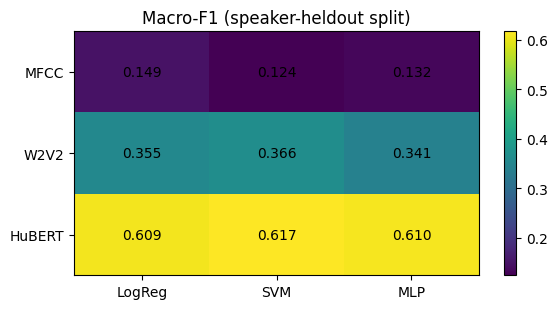

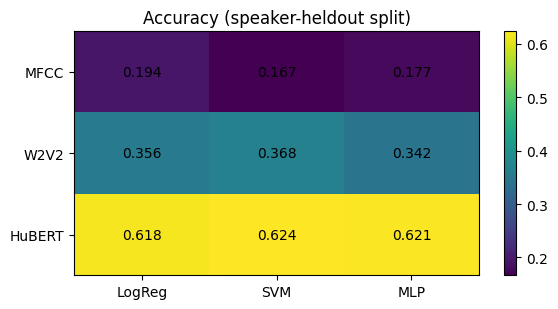

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fill in your results here (acc, macro_f1)
results = [
    ("MFCC",  "LogReg", 0.1938, 0.1486),
    ("MFCC",  "SVM",    0.1665, 0.1241),
    ("MFCC",  "MLP",    0.1773, 0.1324),

    ("W2V2",  "LogReg", 0.3565, 0.3547),
    ("W2V2",  "SVM",    0.3677, 0.3663),
    ("W2V2",  "MLP",    0.3419, 0.3411),

    ("HuBERT","LogReg", 0.6177, 0.6088),
    ("HuBERT","SVM",    0.6235, 0.6167),
    ("HuBERT","MLP",    0.6208, 0.6099),
]

df = pd.DataFrame(results, columns=["features","model","acc","macro_f1"])

# --- Heatmap for macro-F1 ---
pivot_f1 = df.pivot(index="features", columns="model", values="macro_f1").loc[["MFCC","W2V2","HuBERT"], ["LogReg","SVM","MLP"]]

plt.figure(figsize=(6, 3.2))
im = plt.imshow(pivot_f1.values, aspect="auto")
plt.xticks(range(pivot_f1.shape[1]), pivot_f1.columns)
plt.yticks(range(pivot_f1.shape[0]), pivot_f1.index)
plt.title("Macro-F1 (speaker-heldout split)")
plt.colorbar(im)

# annotate
for i in range(pivot_f1.shape[0]):
    for j in range(pivot_f1.shape[1]):
        plt.text(j, i, f"{pivot_f1.values[i,j]:.3f}", ha="center", va="center")

plt.tight_layout()
plt.show()

# --- Optional: Heatmap for accuracy ---
pivot_acc = df.pivot(index="features", columns="model", values="acc").loc[["MFCC","W2V2","HuBERT"], ["LogReg","SVM","MLP"]]

plt.figure(figsize=(6, 3.2))
im = plt.imshow(pivot_acc.values, aspect="auto")
plt.xticks(range(pivot_acc.shape[1]), pivot_acc.columns)
plt.yticks(range(pivot_acc.shape[0]), pivot_acc.index)
plt.title("Accuracy (speaker-heldout split)")
plt.colorbar(im)

for i in range(pivot_acc.shape[0]):
    for j in range(pivot_acc.shape[1]):
        plt.text(j, i, f"{pivot_acc.values[i,j]:.3f}", ha="center", va="center")

plt.tight_layout()
plt.show()


In [27]:
import matplotlib.pyplot as plt

# assumes res_df exists with columns: features, model, acc, macro_f1
order_features = ["MFCC","W2V2","HuBERT"]
order_models   = ["LogReg","SVM","MLP"]

pivot_f1 = res_df.pivot(index="features", columns="model", values="macro_f1").reindex(order_features)[order_models]

plt.figure(figsize=(6, 3.2))
im = plt.imshow(pivot_f1.values, aspect="auto")
plt.xticks(range(pivot_f1.shape[1]), pivot_f1.columns)
plt.yticks(range(pivot_f1.shape[0]), pivot_f1.index)
plt.title("Macro-F1 (speaker-heldout split)")
plt.colorbar(im)

for i in range(pivot_f1.shape[0]):
    for j in range(pivot_f1.shape[1]):
        plt.text(j, i, f"{pivot_f1.values[i,j]:.3f}", ha="center", va="center")

plt.tight_layout()
plt.show()


NameError: name 'res_df' is not defined

In [11]:
import os
import numpy as np
import pandas as pd

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt


In [13]:
OUT_ROOT = "/content/drive/MyDrive/accent_saa/out/"
META_PARQUET = os.path.join(OUT_ROOT, "saa_meta.parquet")

meta = pd.read_parquet(META_PARQUET)

L1_MAP = {
    "usa": "usa",
    "uk": "uk",
    "england": "uk",
    "scotland": "uk",
    "wales": "uk",
    "canada": "canada",
    "australia": "australia",
    "new zealand": "australia"
}

meta["country_clean"] = meta["country"].astype(str).str.lower().str.strip()
meta["l1_region"] = meta["country_clean"].map(L1_MAP)

# Keep only L1 English speakers (regions)
meta_l1 = meta[meta["l1_region"].notna()].copy().reset_index(drop=True)

print("L1-region counts (samples):\n", meta_l1["l1_region"].value_counts())
print("\nSpeakers per region:\n", meta_l1.groupby("l1_region")["speakerid"].nunique())
print("\nExample rows:\n", meta_l1[["audio_path","speakerid","country","l1_region"]].head())


L1-region counts (samples):
 l1_region
usa          382
uk            67
canada        52
australia     40
Name: count, dtype: int64

Speakers per region:
 l1_region
australia     40
canada        52
uk            67
usa          382
Name: speakerid, dtype: int64

Example rows:
                                           audio_path  speakerid country  \
0  /content/drive/MyDrive/accent_saa/data/recordi...       1394     usa   
1  /content/drive/MyDrive/accent_saa/data/recordi...       1456     usa   
2  /content/drive/MyDrive/accent_saa/data/recordi...       1805      uk   
3  /content/drive/MyDrive/accent_saa/data/recordi...       1897     usa   
4  /content/drive/MyDrive/accent_saa/data/recordi...         61     usa   

  l1_region  
0       usa  
1       usa  
2        uk  
3       usa  
4       usa  


In [14]:
TARGET_SPK_PER_CLASS = 50
rng = np.random.default_rng(42)

def balance_by_speakers(df, label_col="l1_region", speaker_col="speakerid", target=50, rng=None):
    rng = rng or np.random.default_rng(0)
    chunks = []

    for lab in sorted(df[label_col].unique()):
        spks = df.loc[df[label_col] == lab, speaker_col].dropna().unique()

        if len(spks) == 0:
            continue

        if len(spks) >= target:
            chosen = rng.choice(spks, size=target, replace=False)
        else:
            chosen = rng.choice(spks, size=target, replace=True)

        chunks.append(df[df[speaker_col].isin(chosen)].copy())

    out = pd.concat(chunks, axis=0).reset_index(drop=True)
    return out

meta_bal = balance_by_speakers(meta_l1, target=TARGET_SPK_PER_CLASS, rng=rng)

print("After balancing (samples):\n", meta_bal["l1_region"].value_counts())
print("\nSpeakers per region (should be 50 each):\n", meta_bal.groupby("l1_region")["speakerid"].nunique())
print("\nTotal samples:", len(meta_bal))


After balancing (samples):
 l1_region
canada       50
uk           50
usa          50
australia    29
Name: count, dtype: int64

Speakers per region (should be 50 each):
 l1_region
australia    29
canada       50
uk           50
usa          50
Name: speakerid, dtype: int64

Total samples: 179


In [15]:
# ---------- MFCC ----------
MFCC_NPZ   = os.path.join(OUT_ROOT, "features_mfcc", "mfcc_features.npz")
MFCC_INDEX = os.path.join(OUT_ROOT, "features_mfcc", "mfcc_index.csv")

mfcc = np.load(MFCC_NPZ, allow_pickle=True)
mfcc_index = pd.read_csv(MFCC_INDEX)

# mfcc_index is in the same order as mfcc["X"] / mfcc["y"]
mfcc_index["row_id"] = np.arange(len(mfcc_index))

meta_mfcc = meta_bal.merge(mfcc_index[["audio_path","row_id"]], on="audio_path", how="inner")
meta_mfcc = meta_mfcc.sort_values("row_id").reset_index(drop=True)

X_mfcc = mfcc["X"][meta_mfcc["row_id"].values]
y      = meta_mfcc["l1_region"].values
spk    = meta_mfcc["speakerid"].values

print("MFCC aligned:", X_mfcc.shape, "| labels:", pd.Series(y).value_counts().to_dict())

# ---------- Wav2Vec2 ----------
W2V_NPZ   = os.path.join(OUT_ROOT, "features_wav2vec", "wav2vec_embeddings.npz")
W2V_INDEX = os.path.join(OUT_ROOT, "features_wav2vec", "wav2vec_index.csv")

w2v = np.load(W2V_NPZ, allow_pickle=True)
w2v_index = pd.read_csv(W2V_INDEX)
w2v_index["row_id"] = np.arange(len(w2v_index))

meta_w2v = meta_bal.merge(w2v_index[["audio_path","row_id"]], on="audio_path", how="inner")
meta_w2v = meta_w2v.sort_values("row_id").reset_index(drop=True)

X_w2v = w2v["X"][meta_w2v["row_id"].values]
y_w2v = meta_w2v["l1_region"].values
spk_w2v = meta_w2v["speakerid"].values

print("W2V aligned:", X_w2v.shape, "| labels:", pd.Series(y_w2v).value_counts().to_dict())

# ---------- HuBERT-large ----------
HUBERT_DIR = os.path.join(OUT_ROOT, "features_facebook_hubert-large-ls960-ft")
HUBERT_NPZ = os.path.join(HUBERT_DIR, "embeddings.npz")
HUBERT_INDEX = os.path.join(HUBERT_DIR, "index.csv")

hub = np.load(HUBERT_NPZ, allow_pickle=True)
hub_index = pd.read_csv(HUBERT_INDEX)
hub_index["row_id"] = np.arange(len(hub_index))

meta_hub = meta_bal.merge(hub_index[["audio_path","row_id"]], on="audio_path", how="inner")
meta_hub = meta_hub.sort_values("row_id").reset_index(drop=True)

X_hub = hub["X"][meta_hub["row_id"].values]
y_hub = meta_hub["l1_region"].values
spk_hub = meta_hub["speakerid"].values

print("HuBERT aligned:", X_hub.shape, "| labels:", pd.Series(y_hub).value_counts().to_dict())


MFCC aligned: (179, 120) | labels: {'uk': 50, 'canada': 50, 'usa': 50, 'australia': 29}
W2V aligned: (179, 768) | labels: {'uk': 50, 'canada': 50, 'usa': 50, 'australia': 29}
HuBERT aligned: (179, 1024) | labels: {'uk': 50, 'canada': 50, 'usa': 50, 'australia': 29}


In [21]:
from sklearn.model_selection import train_test_split

def stratified_split(y, test_size=0.20, seed=42):
    idx = np.arange(len(y))
    train_idx, test_idx = train_test_split(
        idx,
        test_size=test_size,
        random_state=seed,
        stratify=y
    )
    return train_idx, test_idx

# --- MFCC ---
train_mfcc, test_mfcc = stratified_split(y, test_size=0.20, seed=42)

# --- Wav2Vec2 ---
train_w2v, test_w2v = stratified_split(y_w2v, test_size=0.20, seed=42)

# --- HuBERT ---
train_hub, test_hub = stratified_split(y_hub, test_size=0.20, seed=42)

print("Train/Test MFCC:", len(train_mfcc), len(test_mfcc))
print("Train/Test W2V :", len(train_w2v),  len(test_w2v))
print("Train/Test HuB :", len(train_hub),  len(test_hub))

print("\nMFCC test label counts:\n", pd.Series(y[test_mfcc]).value_counts())
print("\nW2V  test label counts:\n", pd.Series(y_w2v[test_w2v]).value_counts())
print("\nHuB  test label counts:\n", pd.Series(y_hub[test_hub]).value_counts())


Train/Test MFCC: 143 36
Train/Test W2V : 143 36
Train/Test HuB : 143 36

MFCC test label counts:
 usa          10
canada       10
uk           10
australia     6
Name: count, dtype: int64

W2V  test label counts:
 usa          10
canada       10
uk           10
australia     6
Name: count, dtype: int64

HuB  test label counts:
 usa          10
canada       10
uk           10
australia     6
Name: count, dtype: int64


In [22]:
from sklearn.base import clone

def run_clf(X, y, train_idx, test_idx, clf, name):
    Xtr, Xte = X[train_idx], X[test_idx]
    ytr, yte = y[train_idx], y[test_idx]

    clf = clone(clf)
    clf.fit(Xtr, ytr)
    yp = clf.predict(Xte)

    acc = accuracy_score(yte, yp)
    f1  = f1_score(yte, yp, average="macro")

    print(f"[{name}] acc={acc:.4f}  macro-F1={f1:.4f}")
    return acc, f1

# models
CLF_LOGREG = make_pipeline(StandardScaler(), LogisticRegression(max_iter=3000))
CLF_SVM    = make_pipeline(StandardScaler(), SVC(kernel="rbf"))
CLF_MLP    = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(256,128), max_iter=400, random_state=42))

print("=== MFCC ===")
run_clf(X_mfcc, y, train_mfcc, test_mfcc, CLF_LOGREG, "MFCC + LogReg")
run_clf(X_mfcc, y, train_mfcc, test_mfcc, CLF_SVM,    "MFCC + SVM")
run_clf(X_mfcc, y, train_mfcc, test_mfcc, CLF_MLP,    "MFCC + MLP")

print("\n=== Wav2Vec2 ===")
run_clf(X_w2v, y_w2v, train_w2v, test_w2v, CLF_LOGREG, "W2V2 + LogReg")
run_clf(X_w2v, y_w2v, train_w2v, test_w2v, CLF_SVM,    "W2V2 + SVM")
run_clf(X_w2v, y_w2v, train_w2v, test_w2v, CLF_MLP,    "W2V2 + MLP")

print("\n=== HuBERT-large ===")
run_clf(X_hub, y_hub, train_hub, test_hub, CLF_LOGREG, "HuBERT + LogReg")
run_clf(X_hub, y_hub, train_hub, test_hub, CLF_SVM,    "HuBERT + SVM")
run_clf(X_hub, y_hub, train_hub, test_hub, CLF_MLP,    "HuBERT + MLP")


=== MFCC ===
[MFCC + LogReg] acc=0.3056  macro-F1=0.2875
[MFCC + SVM] acc=0.3889  macro-F1=0.3134
[MFCC + MLP] acc=0.2500  macro-F1=0.2390

=== Wav2Vec2 ===
[W2V2 + LogReg] acc=0.6389  macro-F1=0.6288
[W2V2 + SVM] acc=0.5000  macro-F1=0.3974
[W2V2 + MLP] acc=0.5833  macro-F1=0.5753

=== HuBERT-large ===
[HuBERT + LogReg] acc=0.6944  macro-F1=0.6848
[HuBERT + SVM] acc=0.5556  macro-F1=0.4421
[HuBERT + MLP] acc=0.6111  macro-F1=0.5999


(0.6111111111111112, 0.5998803827751196)

=== MFCC + SVM CM ===


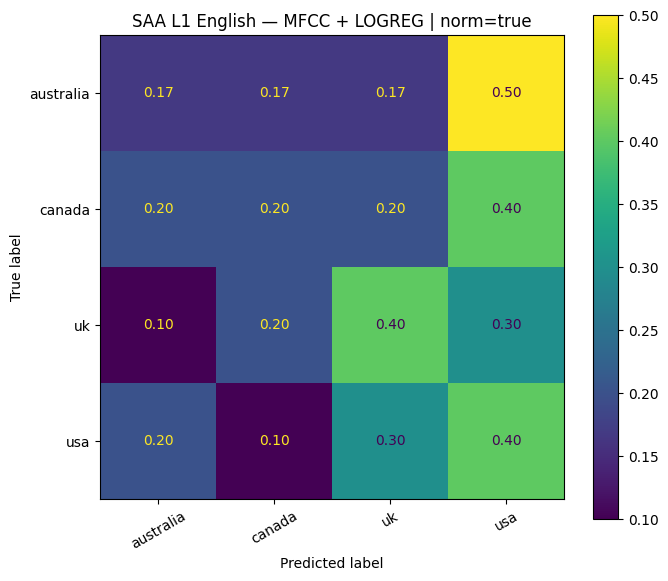

Classification report:
              precision    recall  f1-score   support

   australia     0.1667    0.1667    0.1667         6
      canada     0.3333    0.2000    0.2500        10
          uk     0.4000    0.4000    0.4000        10
         usa     0.2857    0.4000    0.3333        10

    accuracy                         0.3056        36
   macro avg     0.2964    0.2917    0.2875        36
weighted avg     0.3108    0.3056    0.3009        36


=== W2V2 + SVM CM ===


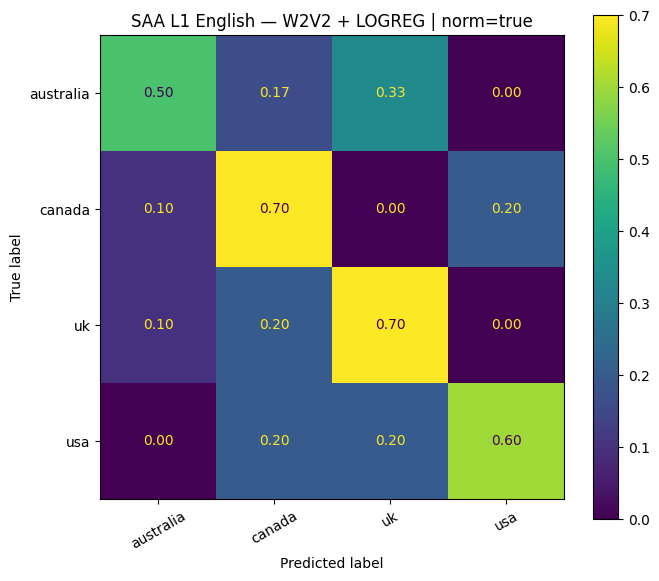

Classification report:
              precision    recall  f1-score   support

   australia     0.6000    0.5000    0.5455         6
      canada     0.5833    0.7000    0.6364        10
          uk     0.6364    0.7000    0.6667        10
         usa     0.7500    0.6000    0.6667        10

    accuracy                         0.6389        36
   macro avg     0.6424    0.6250    0.6288        36
weighted avg     0.6471    0.6389    0.6380        36


=== HuBERT + SVM CM ===


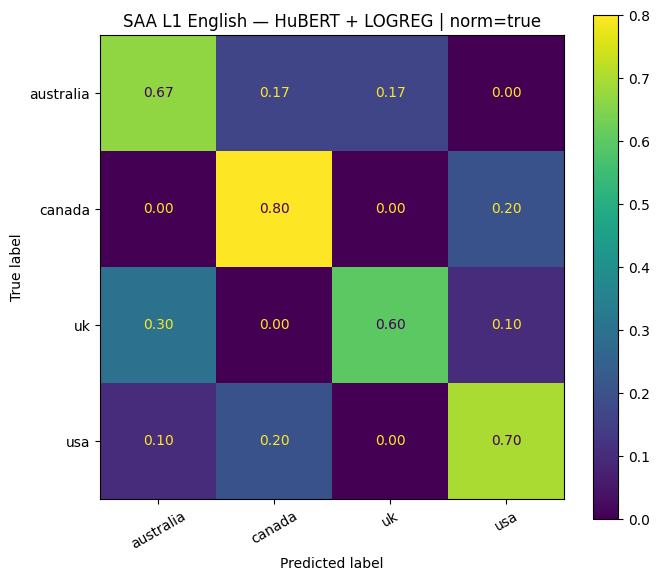

Classification report:
              precision    recall  f1-score   support

   australia     0.5000    0.6667    0.5714         6
      canada     0.7273    0.8000    0.7619        10
          uk     0.8571    0.6000    0.7059        10
         usa     0.7000    0.7000    0.7000        10

    accuracy                         0.6944        36
   macro avg     0.6961    0.6917    0.6848        36
weighted avg     0.7179    0.6944    0.6974        36

=== MFCC + SVM CM ===


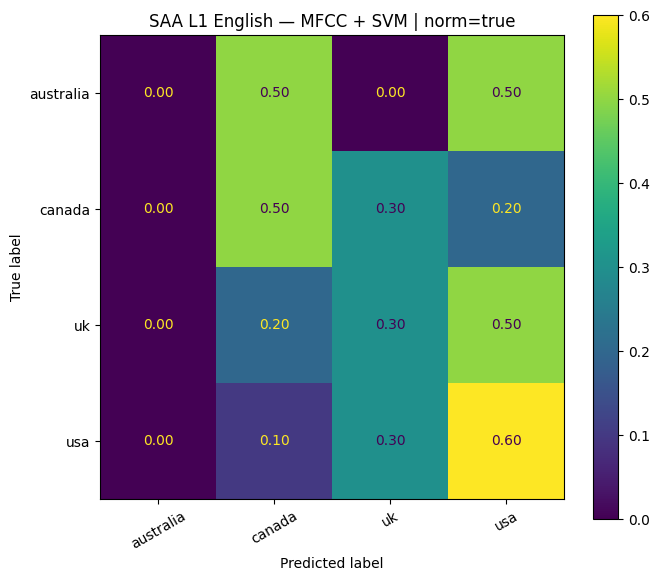

Classification report:
              precision    recall  f1-score   support

   australia     0.0000    0.0000    0.0000         6
      canada     0.4545    0.5000    0.4762        10
          uk     0.3333    0.3000    0.3158        10
         usa     0.3750    0.6000    0.4615        10

    accuracy                         0.3889        36
   macro avg     0.2907    0.3500    0.3134        36
weighted avg     0.3230    0.3889    0.3482        36


=== W2V2 + SVM CM ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


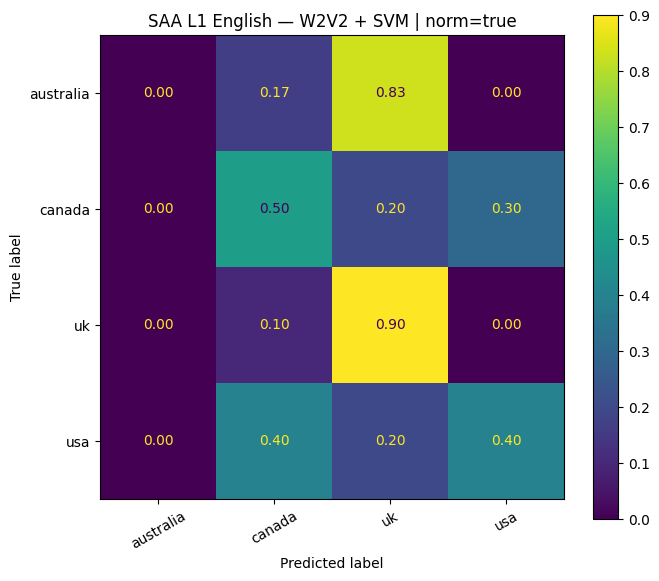

Classification report:
              precision    recall  f1-score   support

   australia     0.0000    0.0000    0.0000         6
      canada     0.4545    0.5000    0.4762        10
          uk     0.5000    0.9000    0.6429        10
         usa     0.5714    0.4000    0.4706        10

    accuracy                         0.5000        36
   macro avg     0.3815    0.4500    0.3974        36
weighted avg     0.4239    0.5000    0.4416        36


=== HuBERT + SVM CM ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


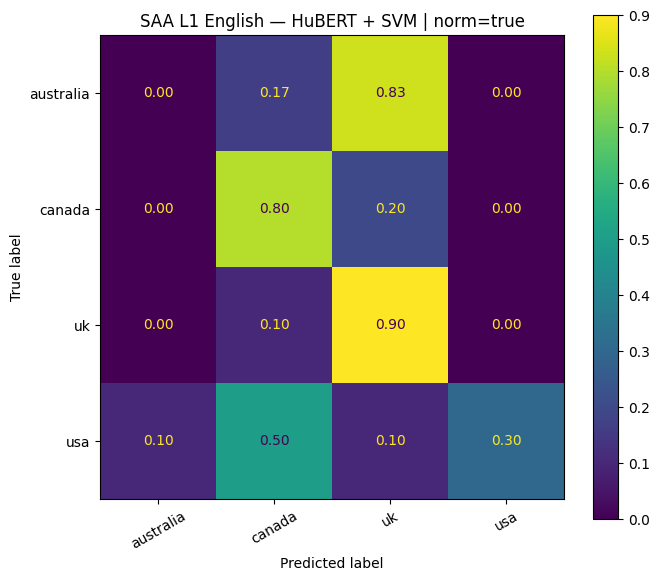

Classification report:
              precision    recall  f1-score   support

   australia     0.0000    0.0000    0.0000         6
      canada     0.5333    0.8000    0.6400        10
          uk     0.5294    0.9000    0.6667        10
         usa     1.0000    0.3000    0.4615        10

    accuracy                         0.5556        36
   macro avg     0.5157    0.5000    0.4421        36
weighted avg     0.5730    0.5556    0.4912        36

=== MFCC + SVM CM ===


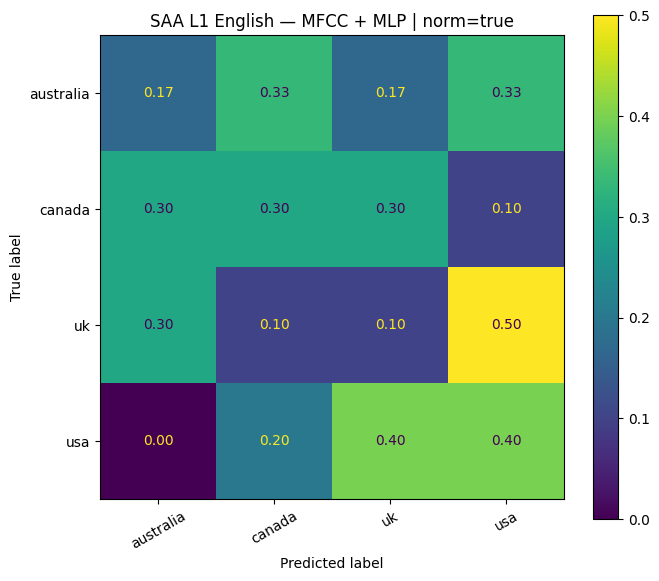

Classification report:
              precision    recall  f1-score   support

   australia     0.1429    0.1667    0.1538         6
      canada     0.3750    0.3000    0.3333        10
          uk     0.1111    0.1000    0.1053        10
         usa     0.3333    0.4000    0.3636        10

    accuracy                         0.2500        36
   macro avg     0.2406    0.2417    0.2390        36
weighted avg     0.2514    0.2500    0.2485        36


=== W2V2 + SVM CM ===


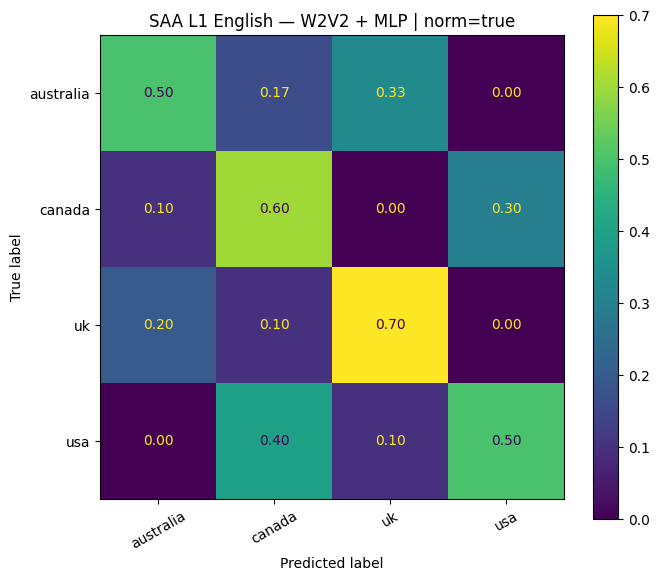

Classification report:
              precision    recall  f1-score   support

   australia     0.5000    0.5000    0.5000         6
      canada     0.5000    0.6000    0.5455        10
          uk     0.7000    0.7000    0.7000        10
         usa     0.6250    0.5000    0.5556        10

    accuracy                         0.5833        36
   macro avg     0.5813    0.5750    0.5753        36
weighted avg     0.5903    0.5833    0.5836        36


=== HuBERT + SVM CM ===


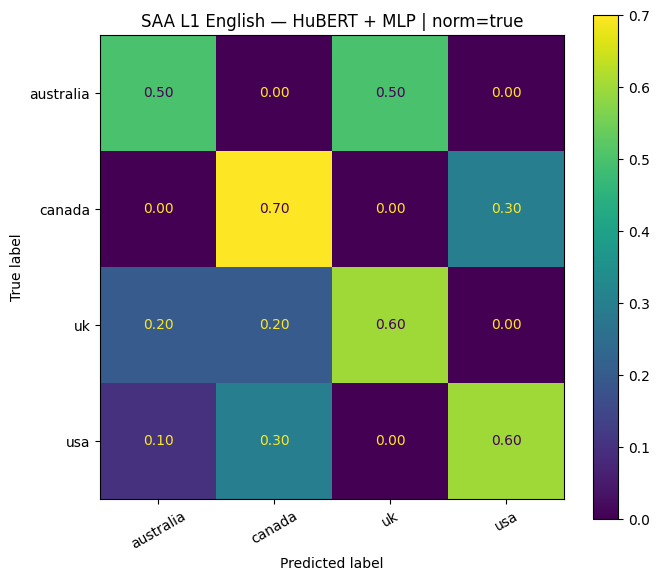

Classification report:
              precision    recall  f1-score   support

   australia     0.5000    0.5000    0.5000         6
      canada     0.5833    0.7000    0.6364        10
          uk     0.6667    0.6000    0.6316        10
         usa     0.6667    0.6000    0.6316        10

    accuracy                         0.6111        36
   macro avg     0.6042    0.6000    0.5999        36
weighted avg     0.6157    0.6111    0.6110        36



In [25]:
def plot_cm(X, y, train_idx, test_idx, clf, title="", normalize="true"):
    Xtr, Xte = X[train_idx], X[test_idx]
    ytr, yte = y[train_idx], y[test_idx]

    clf.fit(Xtr, ytr)
    yp = clf.predict(Xte)

    labels = np.unique(np.concatenate([yte, yp]))
    cm = confusion_matrix(yte, yp, labels=labels, normalize=normalize)

    fig, ax = plt.subplots(figsize=(7, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation=30, values_format=".2f")
    ax.set_title(title + f" | norm={normalize}")
    plt.tight_layout()
    plt.show()

    print("Classification report:")
    print(classification_report(yte, yp, digits=4))
    return yp

CLF_SVM = make_pipeline(StandardScaler(), SVC(kernel="rbf"))

print("=== MFCC + SVM CM ===")
_ = plot_cm(X_mfcc, y, train_mfcc, test_mfcc, CLF_LOGREG, "SAA L1 English — MFCC + LOGREG", normalize="true")

print("\n=== W2V2 + SVM CM ===")
_ = plot_cm(X_w2v, y_w2v, train_w2v, test_w2v, CLF_LOGREG, "SAA L1 English — W2V2 + LOGREG", normalize="true")

print("\n=== HuBERT + SVM CM ===")
_ = plot_cm(X_hub, y_hub, train_hub, test_hub, CLF_LOGREG, "SAA L1 English — HuBERT + LOGREG", normalize="true")


print("=== MFCC + SVM CM ===")
_ = plot_cm(X_mfcc, y, train_mfcc, test_mfcc, CLF_SVM, "SAA L1 English — MFCC + SVM", normalize="true")

print("\n=== W2V2 + SVM CM ===")
_ = plot_cm(X_w2v, y_w2v, train_w2v, test_w2v, CLF_SVM, "SAA L1 English — W2V2 + SVM", normalize="true")

print("\n=== HuBERT + SVM CM ===")
_ = plot_cm(X_hub, y_hub, train_hub, test_hub, CLF_SVM, "SAA L1 English — HuBERT + SVM", normalize="true")


print("=== MFCC + SVM CM ===")
_ = plot_cm(X_mfcc, y, train_mfcc, test_mfcc, CLF_MLP, "SAA L1 English — MFCC + MLP", normalize="true")

print("\n=== W2V2 + SVM CM ===")
_ = plot_cm(X_w2v, y_w2v, train_w2v, test_w2v, CLF_MLP, "SAA L1 English — W2V2 + MLP", normalize="true")

print("\n=== HuBERT + SVM CM ===")
_ = plot_cm(X_hub, y_hub, train_hub, test_hub, CLF_MLP, "SAA L1 English — HuBERT + MLP", normalize="true")

Train: 932  Test: 234
[SAA | MFCC + LogReg] acc=0.4274  macro-F1=0.1808
[SAA | MFCC + SVM] acc=0.4957  macro-F1=0.0853
[SAA | MFCC + MLP] acc=0.4231  macro-F1=0.1531
[SAA | Wav2Vec2 + LogReg] acc=0.6026  macro-F1=0.3845
[SAA | Wav2Vec2 + SVM] acc=0.5983  macro-F1=0.2458
[SAA | Wav2Vec2 + MLP] acc=0.6026  macro-F1=0.3337
[SAA | HuBERT-large + LogReg] acc=0.8077  macro-F1=0.6730
[SAA | HuBERT-large + SVM] acc=0.6453  macro-F1=0.3187
[SAA | HuBERT-large + MLP] acc=0.7479  macro-F1=0.5719


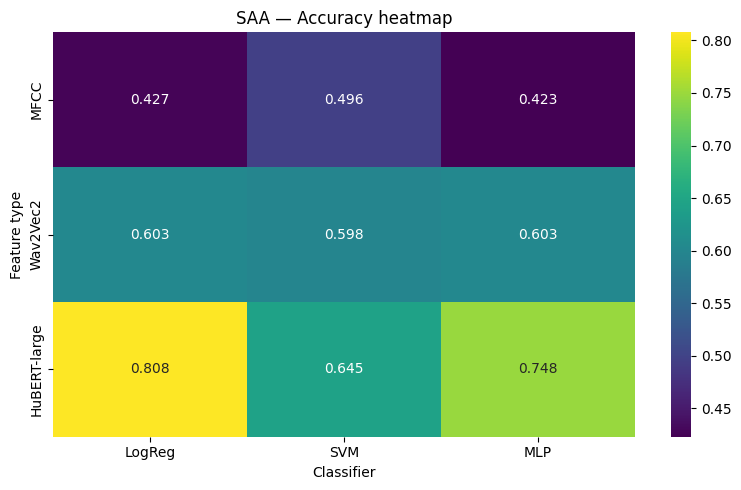

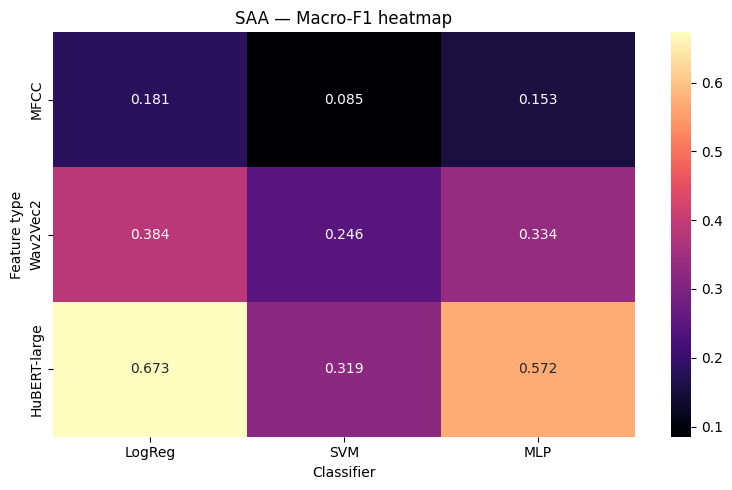

In [28]:
# =========================
# SAA: Load features + meta
# =========================

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns


OUT_DIR = "/content/drive/MyDrive/accent_saa/out"

MFCC_NPZ = os.path.join(OUT_DIR, "features_mfcc/mfcc_features.npz")
W2V_NPZ  = os.path.join(OUT_DIR, "features_wav2vec/wav2vec_embeddings.npz")
HUB_NPZ  = os.path.join(OUT_DIR, "features_facebook_hubert-large-ls960-ft/embeddings.npz")

META_PARQUET = os.path.join(OUT_DIR, "saa_meta.parquet")


meta = pd.read_parquet(META_PARQUET)

mfcc = np.load(MFCC_NPZ)
w2v  = np.load(W2V_NPZ)
hub  = np.load(HUB_NPZ)

X_mfcc = mfcc["X"]
X_w2v  = w2v["X"]
X_hub  = hub["X"]

y = mfcc["y"]   # same labels for all 3


# =========================
# 4:1 random split
# =========================

X_idx = np.arange(len(y))
train_idx, test_idx = train_test_split(
    X_idx,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Train:", len(train_idx), " Test:", len(test_idx))


# =========================
# Models
# =========================

models = {
    "LogReg": make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000)),
    "SVM":    make_pipeline(StandardScaler(), SVC(kernel="rbf")),
    "MLP":    make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(256,128), max_iter=200))
}

features = {
    "MFCC": X_mfcc,
    "Wav2Vec2": X_w2v,
    "HuBERT-large": X_hub
}


# =========================
# Run all combinations
# =========================

results_acc = pd.DataFrame(index=features.keys(), columns=models.keys(), dtype=float)
results_f1  = pd.DataFrame(index=features.keys(), columns=models.keys(), dtype=float)

for feat_name, X in features.items():
    Xtr, Xte = X[train_idx], X[test_idx]
    ytr, yte = y[train_idx], y[test_idx]

    for model_name, clf in models.items():
        clf.fit(Xtr, ytr)
        yp = clf.predict(Xte)

        acc = accuracy_score(yte, yp)
        f1  = f1_score(yte, yp, average="macro")

        results_acc.loc[feat_name, model_name] = acc
        results_f1.loc[feat_name, model_name]  = f1

        print(f"[SAA | {feat_name} + {model_name}] acc={acc:.4f}  macro-F1={f1:.4f}")


# =========================
# Heatmaps
# =========================

plt.figure(figsize=(8, 5))
sns.heatmap(results_acc.astype(float), annot=True, fmt=".3f", cmap="viridis")
plt.title("SAA — Accuracy heatmap")
plt.ylabel("Feature type")
plt.xlabel("Classifier")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 5))
sns.heatmap(results_f1.astype(float), annot=True, fmt=".3f", cmap="magma")
plt.title("SAA — Macro-F1 heatmap")
plt.ylabel("Feature type")
plt.xlabel("Classifier")
plt.tight_layout()
plt.show()


Accuracy table:
               LogReg     SVM     MLP
MFCC          0.3056  0.3889  0.2500
Wav2Vec2      0.6389  0.5000  0.5833
HuBERT-large  0.6944  0.5556  0.6111 

Macro-F1 table:
               LogReg     SVM     MLP
MFCC          0.2875  0.3134  0.2390
Wav2Vec2      0.6288  0.3974  0.5753
HuBERT-large  0.6848  0.4421  0.5999


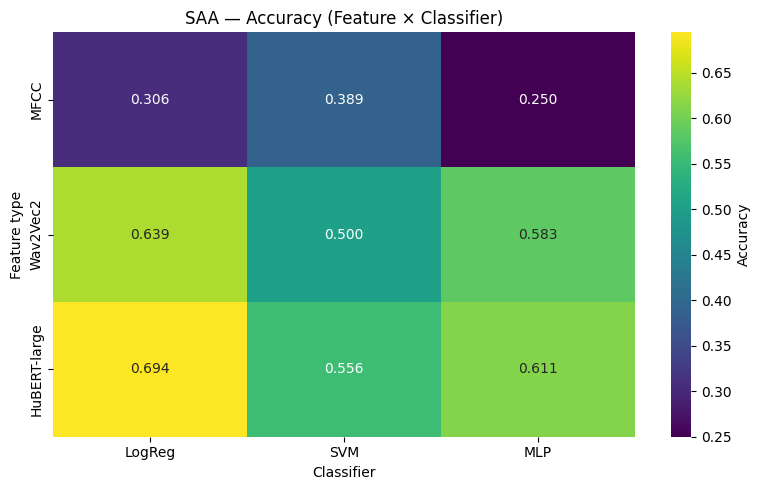

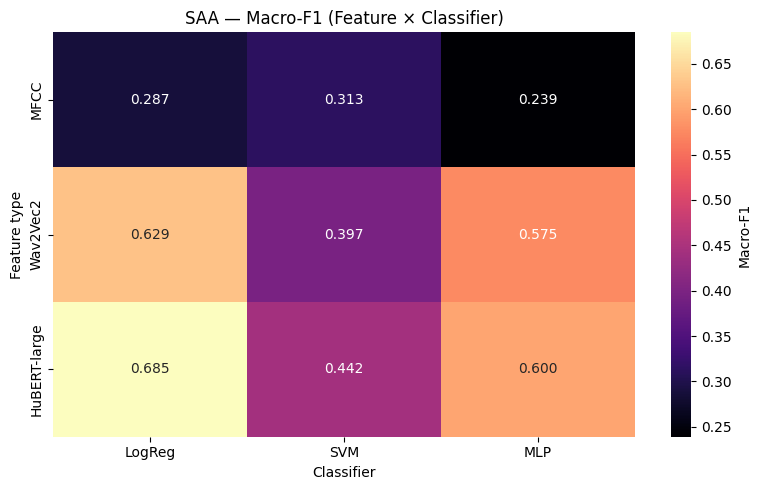

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# Hard-coded SAA results
# =========================

results_acc = pd.DataFrame(
    {
        "LogReg": [0.3056, 0.6389, 0.6944],
        "SVM":    [0.3889, 0.5000, 0.5556],
        "MLP":    [0.2500, 0.5833, 0.6111],
    },
    index=["MFCC", "Wav2Vec2", "HuBERT-large"]
)

results_f1 = pd.DataFrame(
    {
        "LogReg": [0.2875, 0.6288, 0.6848],
        "SVM":    [0.3134, 0.3974, 0.4421],
        "MLP":    [0.2390, 0.5753, 0.5999],
    },
    index=["MFCC", "Wav2Vec2", "HuBERT-large"]
)

print("Accuracy table:\n", results_acc, "\n")
print("Macro-F1 table:\n", results_f1)


# =========================
# Accuracy heatmap
# =========================

plt.figure(figsize=(8, 5))
sns.heatmap(
    results_acc,
    annot=True,
    fmt=".3f",
    cmap="viridis",
    cbar_kws={"label": "Accuracy"}
)
plt.title("SAA — Accuracy (Feature × Classifier)")
plt.ylabel("Feature type")
plt.xlabel("Classifier")
plt.tight_layout()
plt.show()


# =========================
# Macro-F1 heatmap
# =========================

plt.figure(figsize=(8, 5))
sns.heatmap(
    results_f1,
    annot=True,
    fmt=".3f",
    cmap="magma",
    cbar_kws={"label": "Macro-F1"}
)
plt.title("SAA — Macro-F1 (Feature × Classifier)")
plt.ylabel("Feature type")
plt.xlabel("Classifier")
plt.tight_layout()
plt.show()
